Reminders:

Since the grades are classified using numbers 1-20, we should check for inbalances (i.e. if there's only one 17)

The final report consists of a model, as well as intpreting what the accuracy could mean

https://raw.githubusercontent.com/edsters78/Project_Proposal/main/student-mat.csv <br> 
This is the link to the data set we are using.

In [33]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(scales)
library(dplyr)

# Predicting a Student's Success

## Introduction

- choose predictors and justify it, potentially using sources, visualizations
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question


We, group 18, have decided to look into a dataset measuring factors which contribute to a students academic achievement, where academic achievement is measured by a student's grades. It is of utmost importance for educators to understand which factors (such as age, family income, demographics et cetera) contribute to a students academic success in order to adjust pedagogical practices to support and optimize a students learning. The question that we intend to answer is as follows: **can we accurately predict a student's academic achievement (grade), based on a variety of factors**. We will answer this by creating a machine learning knn classification model that will predict student grades, and based on these predictions, we will relate it back to the true values to assess the models accuracy. 

The dataset that we, group 18, have chosen is called Student Grade Prediction, which is a data set consisting of 33 columns and 395 rows, containing data of students from two different Portuguese secondary education institutes. The columns contain factors that the researchers deemed to be relevant in determining a student's academic achievements. Examples of these factors (variables) include the students sex, there relative health and the amount of time spent studying. 


## Methods and Results

In [3]:
#reading data from web
options(repr.matrix.max.rows = 10)
url<-"https://raw.githubusercontent.com/edsters78/Project_Proposal/main/student-mat.csv"
student_data<-read_csv(url)
#student_data

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In [4]:
#tidying the data
#selecting only the variables that will be most relevant
student_data_clean <- student_data %>%
    select(sex, address, Medu, Fedu, traveltime, studytime, paid, activities, internet, famrel, Dalc, Walc, health, absences, G3) 
#student_data_clean

# student_data_clean_nonly <- student_data_clean %>%
#     mutate(sex = ifelse(sex == "F", 1, 0), #1 is female, 0 is male
#           address = ifelse(address == "U", 1, 0), #1 is Urban, 0 is Rural
#           paid = ifelse(paid == "yes", 1, 0), #1 is yes, 0 is no
#           activities = ifelse(activities == "yes", 1, 0), #1 is yes, 0 is no
#           internet = ifelse(internet == "yes", 1, 0)) #1 is yes, 0 is no
# student_data_clean_nonly

In [5]:
# #splitting into training and testing data
# student_split <- initial_split(student_data_clean_nonly, prop = 0.75, strat = G3)
# student_train <- training(student_split)
# student_test <- testing(student_split)

# student_train
# #student_test

`summarise()` ungrouping output (override with `.groups` argument)



G3,n
<dbl>,<int>
0,38
4,1
5,7
6,15
7,9
⋮,⋮
16,16
17,6
18,12


G3,n
<dbl>,<int>
4,1
20,1
19,5
17,6
5,7
⋮,⋮
8,32
15,33
0,38


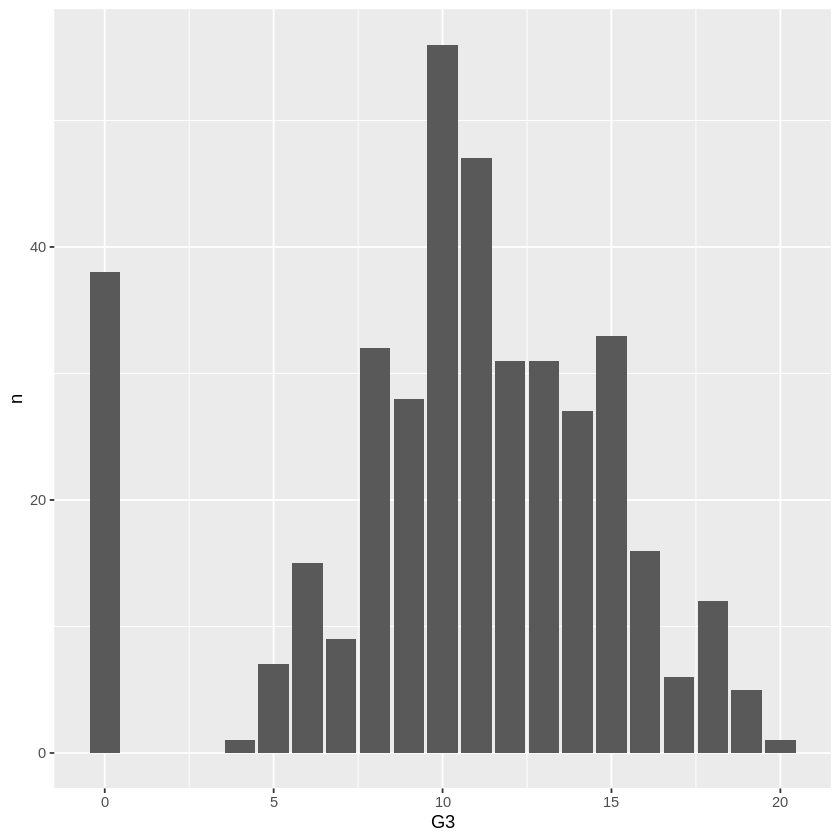

In [6]:
student_G3_count <- student_data %>%
    group_by(G3) %>%
    summarise(n = n())
student_G3_count


student_G3_count_plot <- ggplot(student_G3_count, aes(x = G3, y = n)) +
    geom_bar(stat = "identity")
student_G3_count_plot
        
student_G3_count %>% arrange(n)

In [7]:
#turning grade into a factor

# student_data_clean_temp <- student_data_clean %>%
#     mutate(G3 = as.factor(G3)) %>%
#     select(traveltime, studytime, absences, G3)
# student_data_clean_temp
# student_data_clean_temp_split <- initial_split(student_data_clean_temp)
# student_train_temp <- training(student_data_clean_temp_split)
# student_test_temp <- testing(student_data_clean_temp_split)

# student_train_temp
# student_test_temp

# student_recipe <- recipe(G3 ~., data = student_train_temp) %>%
#     step_scale(all_predictors()) %>%
#     step_center(all_predictors())

# student_vfold <- vfold_cv(student_train_temp, v = 5, strata = G3)

# knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
#     set_engine("kknn") %>%
#     set_mode("classification")

# k_vals <- tibble(neighbors = seq(1:50))

In [8]:
# knn_results <- workflow() %>%
#     add_recipe(student_recipe) %>%
#     add_model(knn_tune) %>%
#     tune_grid(resamples = student_vfold, grid = k_vals) %>%
#     collect_metrics
# knn_results

In [9]:
# accuracies <- knn_results %>%
#     filter(.metric == "accuracy") %>%
#     arrange(desc(mean))
# accuracies

# k_best <- accuracies %>%
#     slice(1) %>%
#     pull(neighbors)
# k_best

In [10]:
# student_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = k_best) %>%
#     set_engine("kknn") %>%
#     set_mode("classification")

# student_model <- workflow() %>%
#     add_recipe(student_recipe) %>%
#     add_model(student_spec) %>%
#     fit(student_train_temp)
# # student_model

# student_predictions <- predict(student_model, student_test_temp)
# student_predictions

# test <- student_predictions %>%
#     group_by(.pred_class) %>%
#     summarise(n = n())
# test

# bind_cols(student_predictions, student_test_temp)

# results <- student_predictions %>%
#     bind_cols(student_test_temp) %>%
#     metrics(truth = G3, estimate = .pred_class)
# results

DATA ANALYSIS STARTS HERE

In [11]:
#creating dataset and categorizing grade
student_data_1 <- student_data %>%
    select(studytime, health, absences, failures, G3)
student_data_F <- mutate(student_data_1, G3 = case_when(G3 %in% (0:4) ~ "D",
                                                       G3 %in% (5:9) ~ "C",
                                                       G3 %in% (10:14) ~ "B",
                                                       G3 %in% (15:20) ~ "A"),
                        G3 = as.factor(G3))
# student_data_F <- mutate(student_data_1, G3 = case_when(G3 %in% (0:9) ~ "Fail",
#                                                        G3 %in% (10:20) ~ "Pass"),
#                         G3 = as.factor(G3))
student_data_F

student_data_F_count <- student_data_F %>% group_by(G3) %>% summarise(n = n())
student_data_F_count

studytime,health,absences,failures,G3
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,3,6,0,C
2,3,4,0,C
2,3,10,3,B
3,5,2,0,A
2,5,4,0,B
⋮,⋮,⋮,⋮,⋮
2,4,11,2,C
1,2,3,0,A
1,3,3,3,C


`summarise()` ungrouping output (override with `.groups` argument)



G3,n
<fct>,<int>
A,73
B,192
C,91
D,39


In [12]:
#splitting into training and testing set
sdf_split <- initial_split(student_data_F, prop = 0.75, strata = G3)
sdf_train <- training(sdf_split)
sdf_test <- testing(sdf_split)

#creating recipe, vfold, tune, and k_vals
# sdf_train_up <- recipe(G3 ~., data = sdf_train) %>%
#     step_upsample(G3, over_ratio = 1, skip = FALSE) %>%
#     prep() %>%
#     bake(sdf_train)
# sdf_train_up
# summarise(group_by(sdf_train_up, G3), n = n())

sdf_recipe <- recipe(G3 ~., data = sdf_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

sdf_vfold<- vfold_cv(sdf_train, v = 5, strata = G3)

sdf_tune <- nearest_neighbor(weight_fun = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 60, by = 5))


In [13]:
#calculating best k
sdf_results <- workflow() %>%
    add_recipe(sdf_recipe) %>%
    add_model(sdf_tune) %>%
    tune_grid(resamples = sdf_vfold, grid = k_vals) %>%
    collect_metrics
sdf_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3949119,5,0.03367751,Model01
1,roc_auc,hand_till,0.5907748,5,0.02872408,Model01
6,accuracy,multiclass,0.4425550,5,0.01255621,Model02
6,roc_auc,hand_till,0.6380282,5,0.01518846,Model02
11,accuracy,multiclass,0.4794202,5,0.01003402,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
46,roc_auc,hand_till,0.6502460,5,0.01402706,Model10
51,accuracy,multiclass,0.4866618,5,0.01102519,Model11
51,roc_auc,hand_till,0.6404636,5,0.01178465,Model11


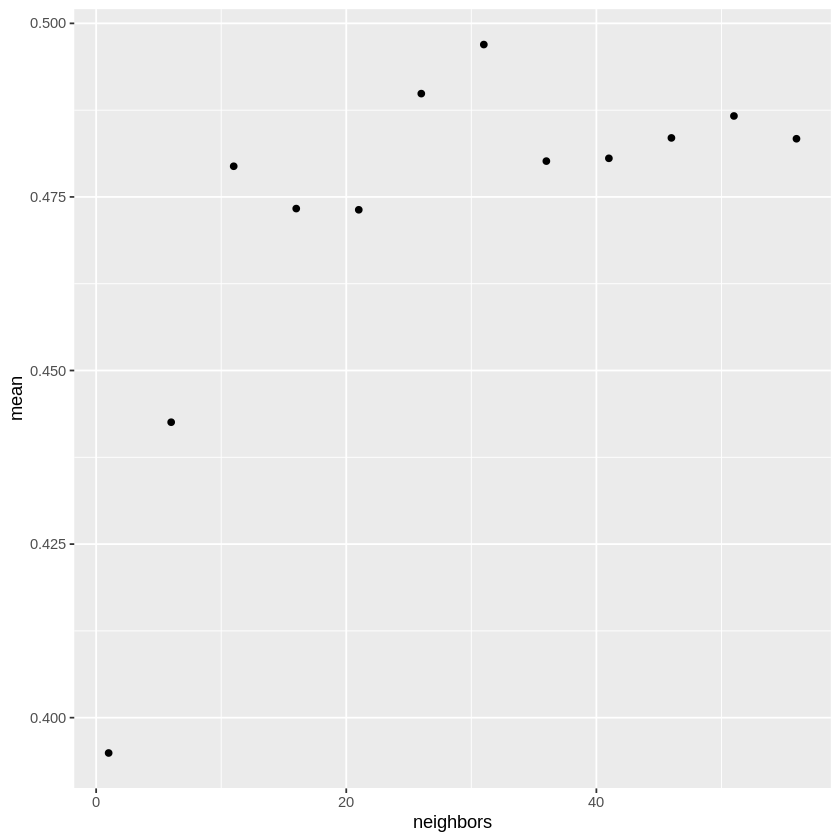

In [14]:
sdf_results %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point()

In [15]:
#pulling out best k (usually 21/26)
sdf_accuracies <- sdf_results %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))
sdf_accuracies

sdf_k_best <- sdf_accuracies %>%
    slice(1) %>%
    pull(neighbors)
sdf_k_best

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,accuracy,multiclass,0.4969484,5,0.01162190,Model07
26,accuracy,multiclass,0.4898822,5,0.01609851,Model06
51,accuracy,multiclass,0.4866618,5,0.01102519,Model11
46,accuracy,multiclass,0.4835021,5,0.01231808,Model10
56,accuracy,multiclass,0.4833813,5,0.00357064,Model12
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,multiclass,0.4794202,5,0.010034020,Model03
16,accuracy,multiclass,0.4733230,5,0.014319798,Model04
21,accuracy,multiclass,0.4731494,5,0.001651771,Model05


[1] 31

In [16]:
#testing accuracy on testing set (usually around 50%)
sdf_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = sdf_k_best) %>%
    set_engine("kknn") %>%
    set_mode("classification")

sdf_model <- workflow() %>%
    add_recipe(sdf_recipe) %>%
    add_model(sdf_spec) %>%
    fit(sdf_train)

sdf_predictions <- predict(sdf_model, sdf_test)

sdf_results <- sdf_predictions %>%
    bind_cols(sdf_test) %>%
    metrics(truth = G3, estimate = .pred_class)
sdf_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.453608247
kap,multiclass,-0.005476237


With 4 categories (0:4 = F, 5:9 = C, 10:14 = B, 15:20 = A)
best k is usually around 21/26, accuracy was around 50%

with 5 categories (0:3 = F, 4:7 = D, 8:11 = C, 12:15 = B, 16:20 = A)
best k is usually around 21 to 31, accuracy is around 40%

using only two categories (0:9 = fail, 10:20 = pass), accuracy is around 40 - 50

If data is upsampled, best k is always 1, data is overfit

studytime,health,absences,failures,G3
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,3,6,0,C
2,3,4,0,C
2,3,10,3,B
3,5,2,0,A
2,5,4,0,B
⋮,⋮,⋮,⋮,⋮
2,4,11,2,C
1,2,3,0,A
1,3,3,3,C


`summarise()` regrouping output by 'studytime' (override with `.groups` argument)

`summarise()` regrouping output by 'health' (override with `.groups` argument)



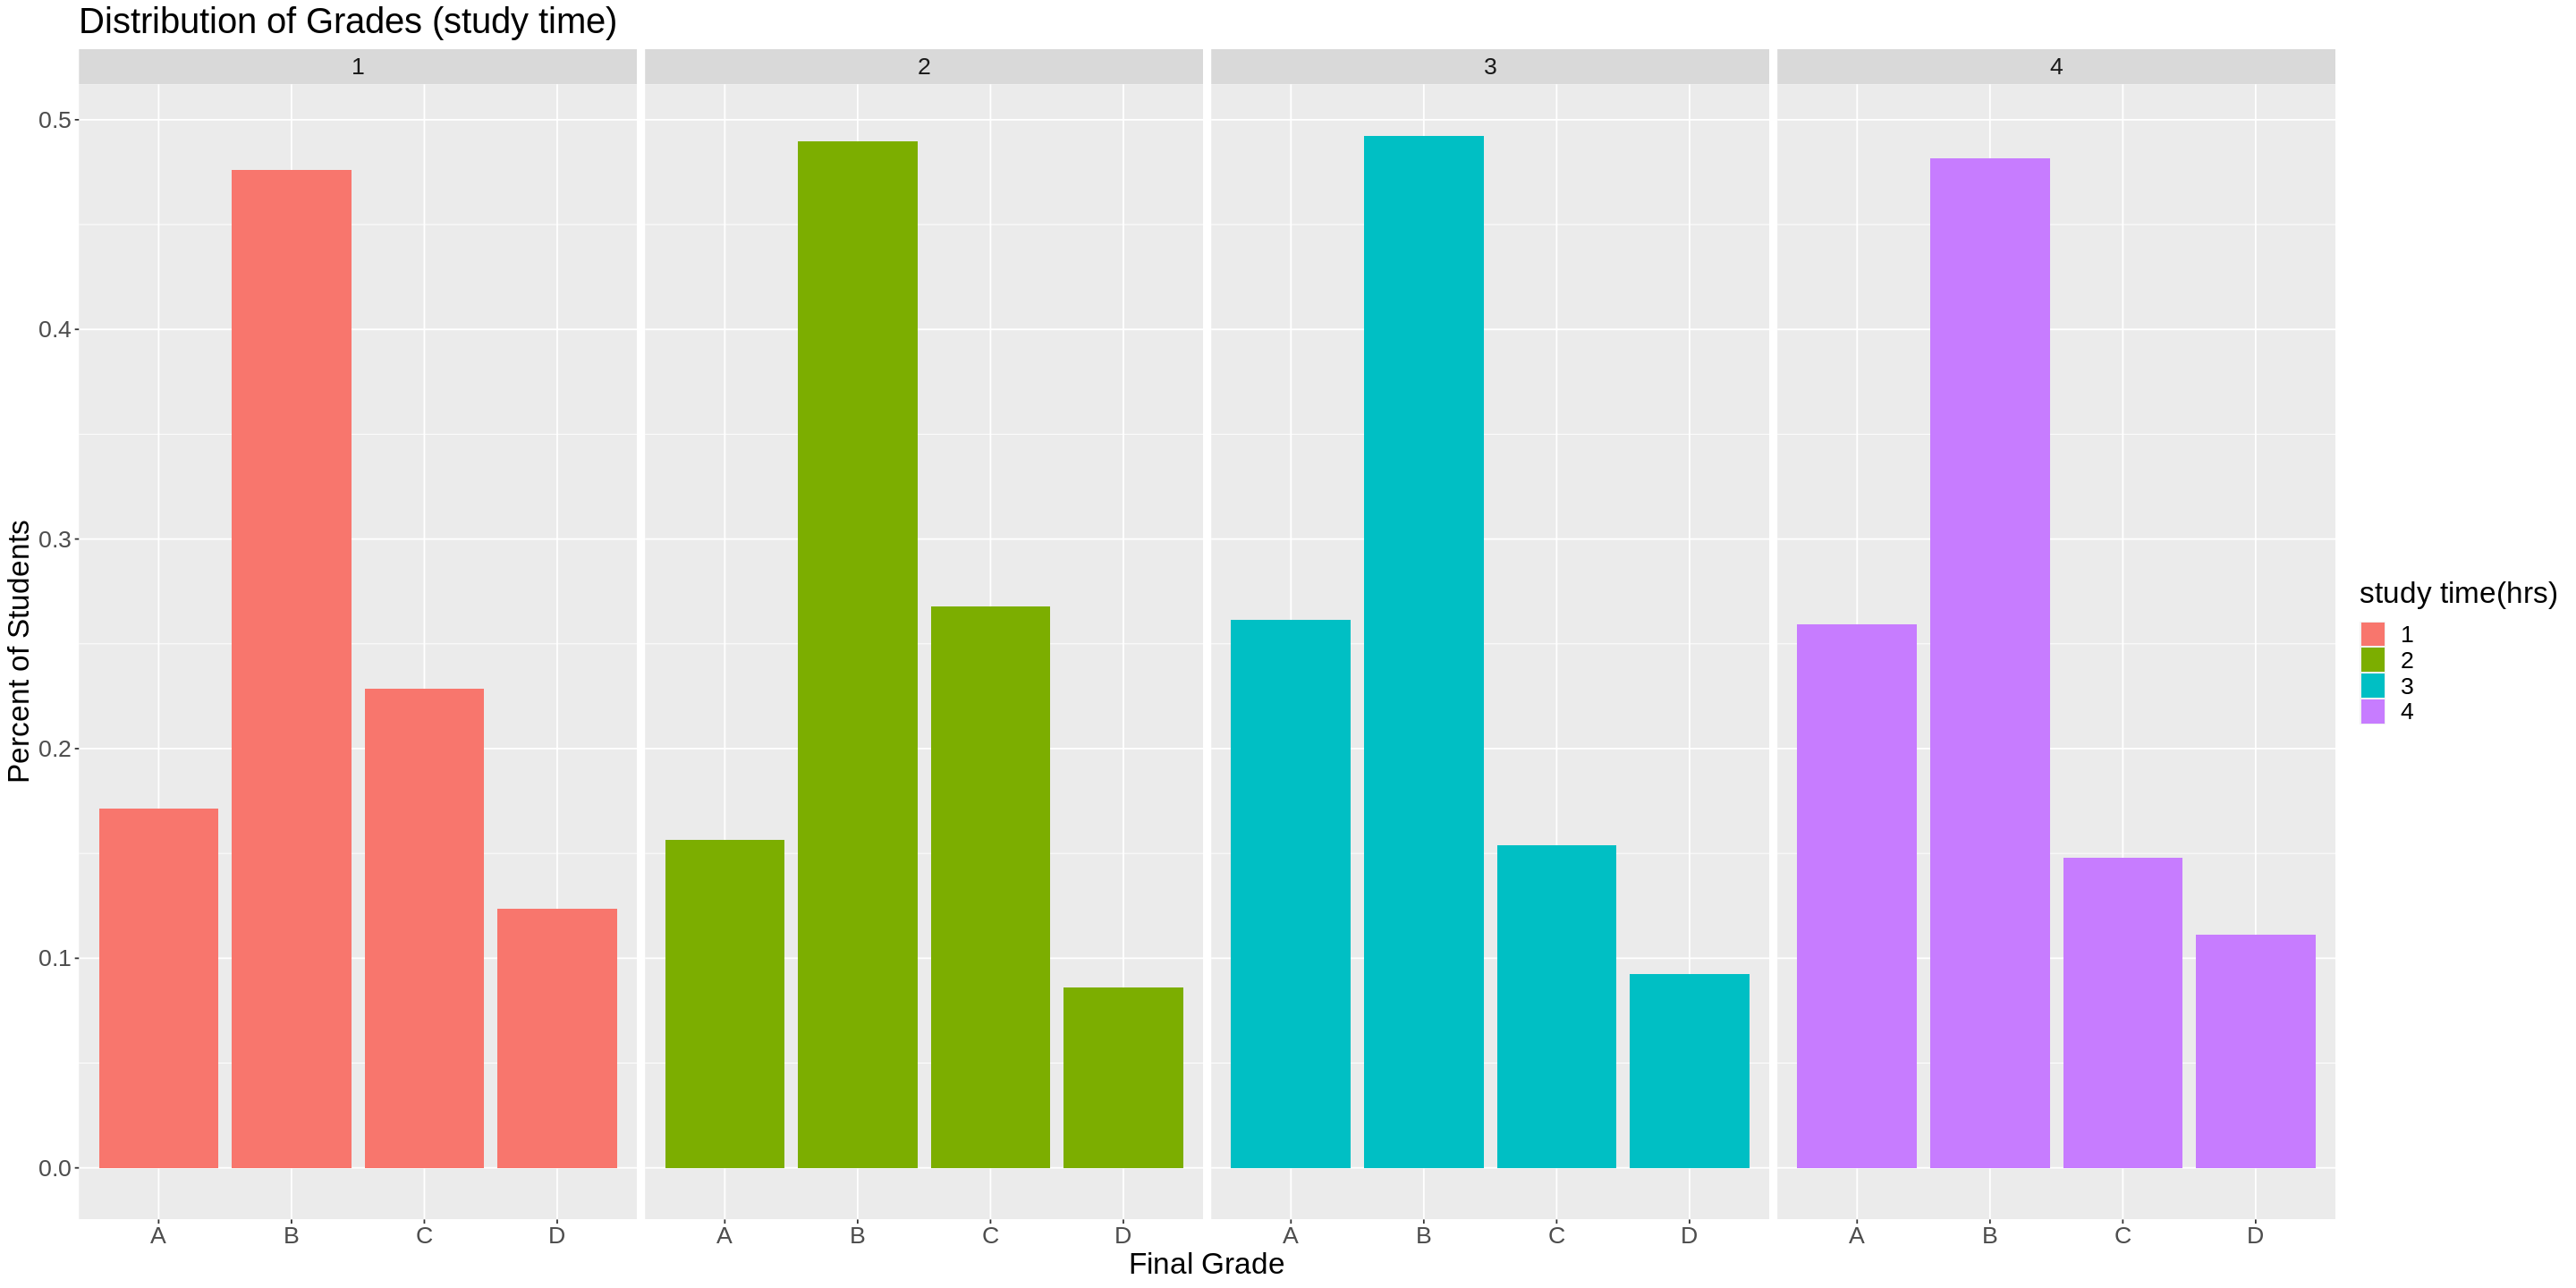

`summarise()` regrouping output by 'failures' (override with `.groups` argument)



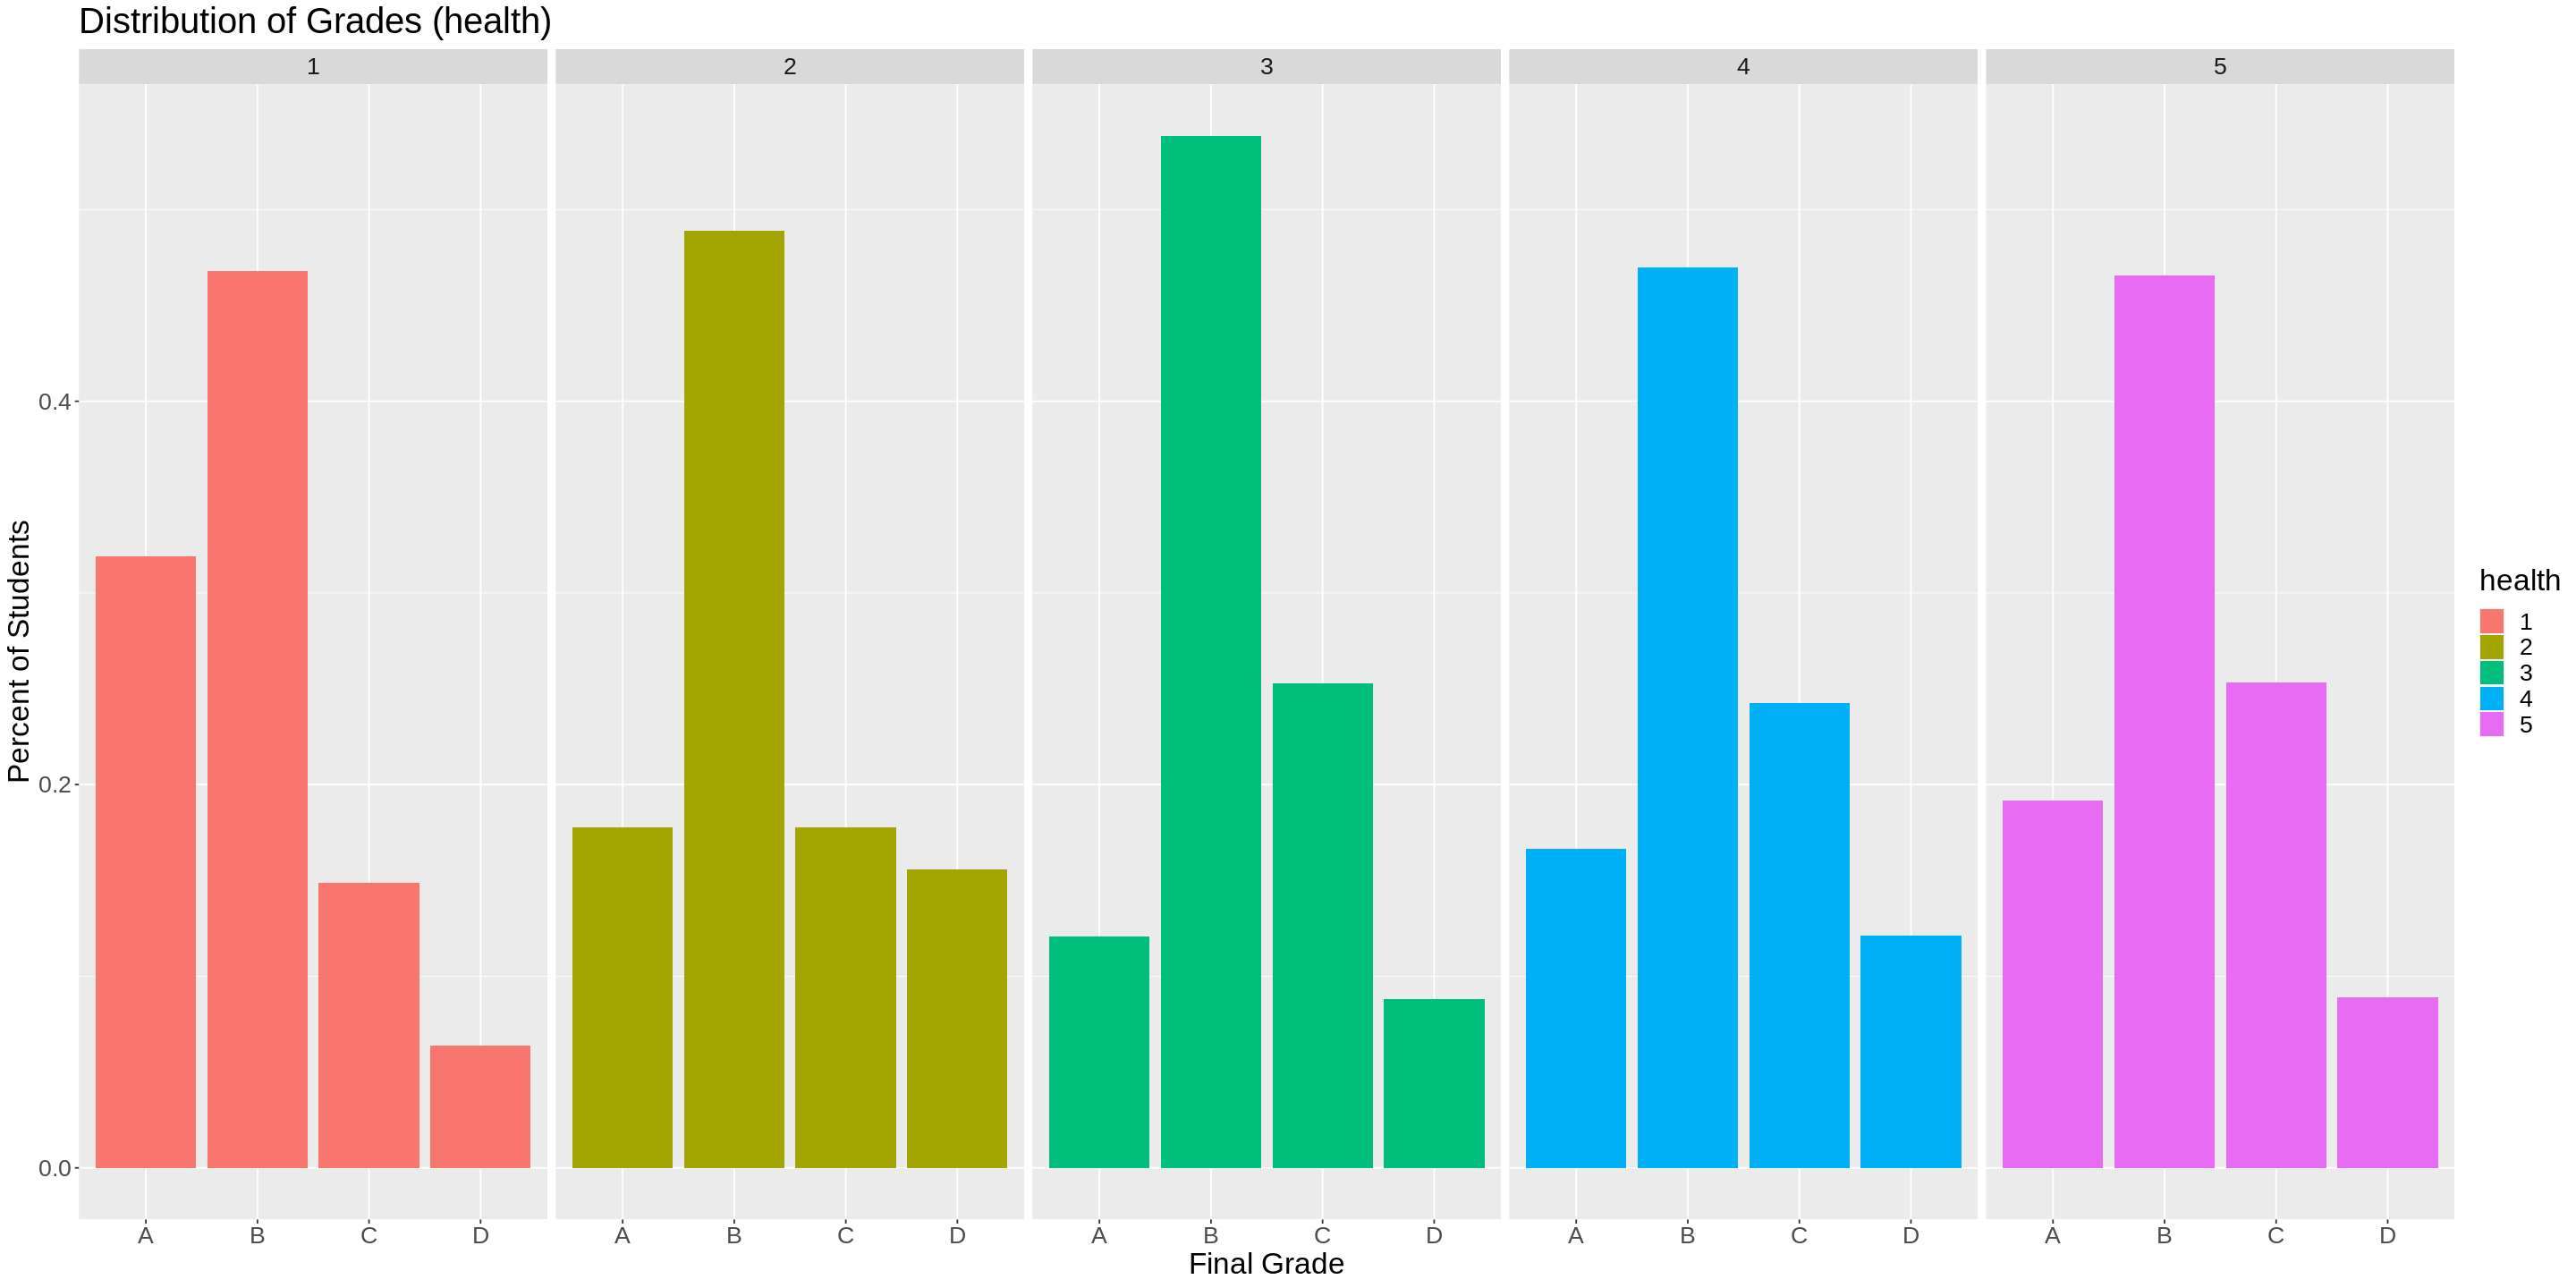

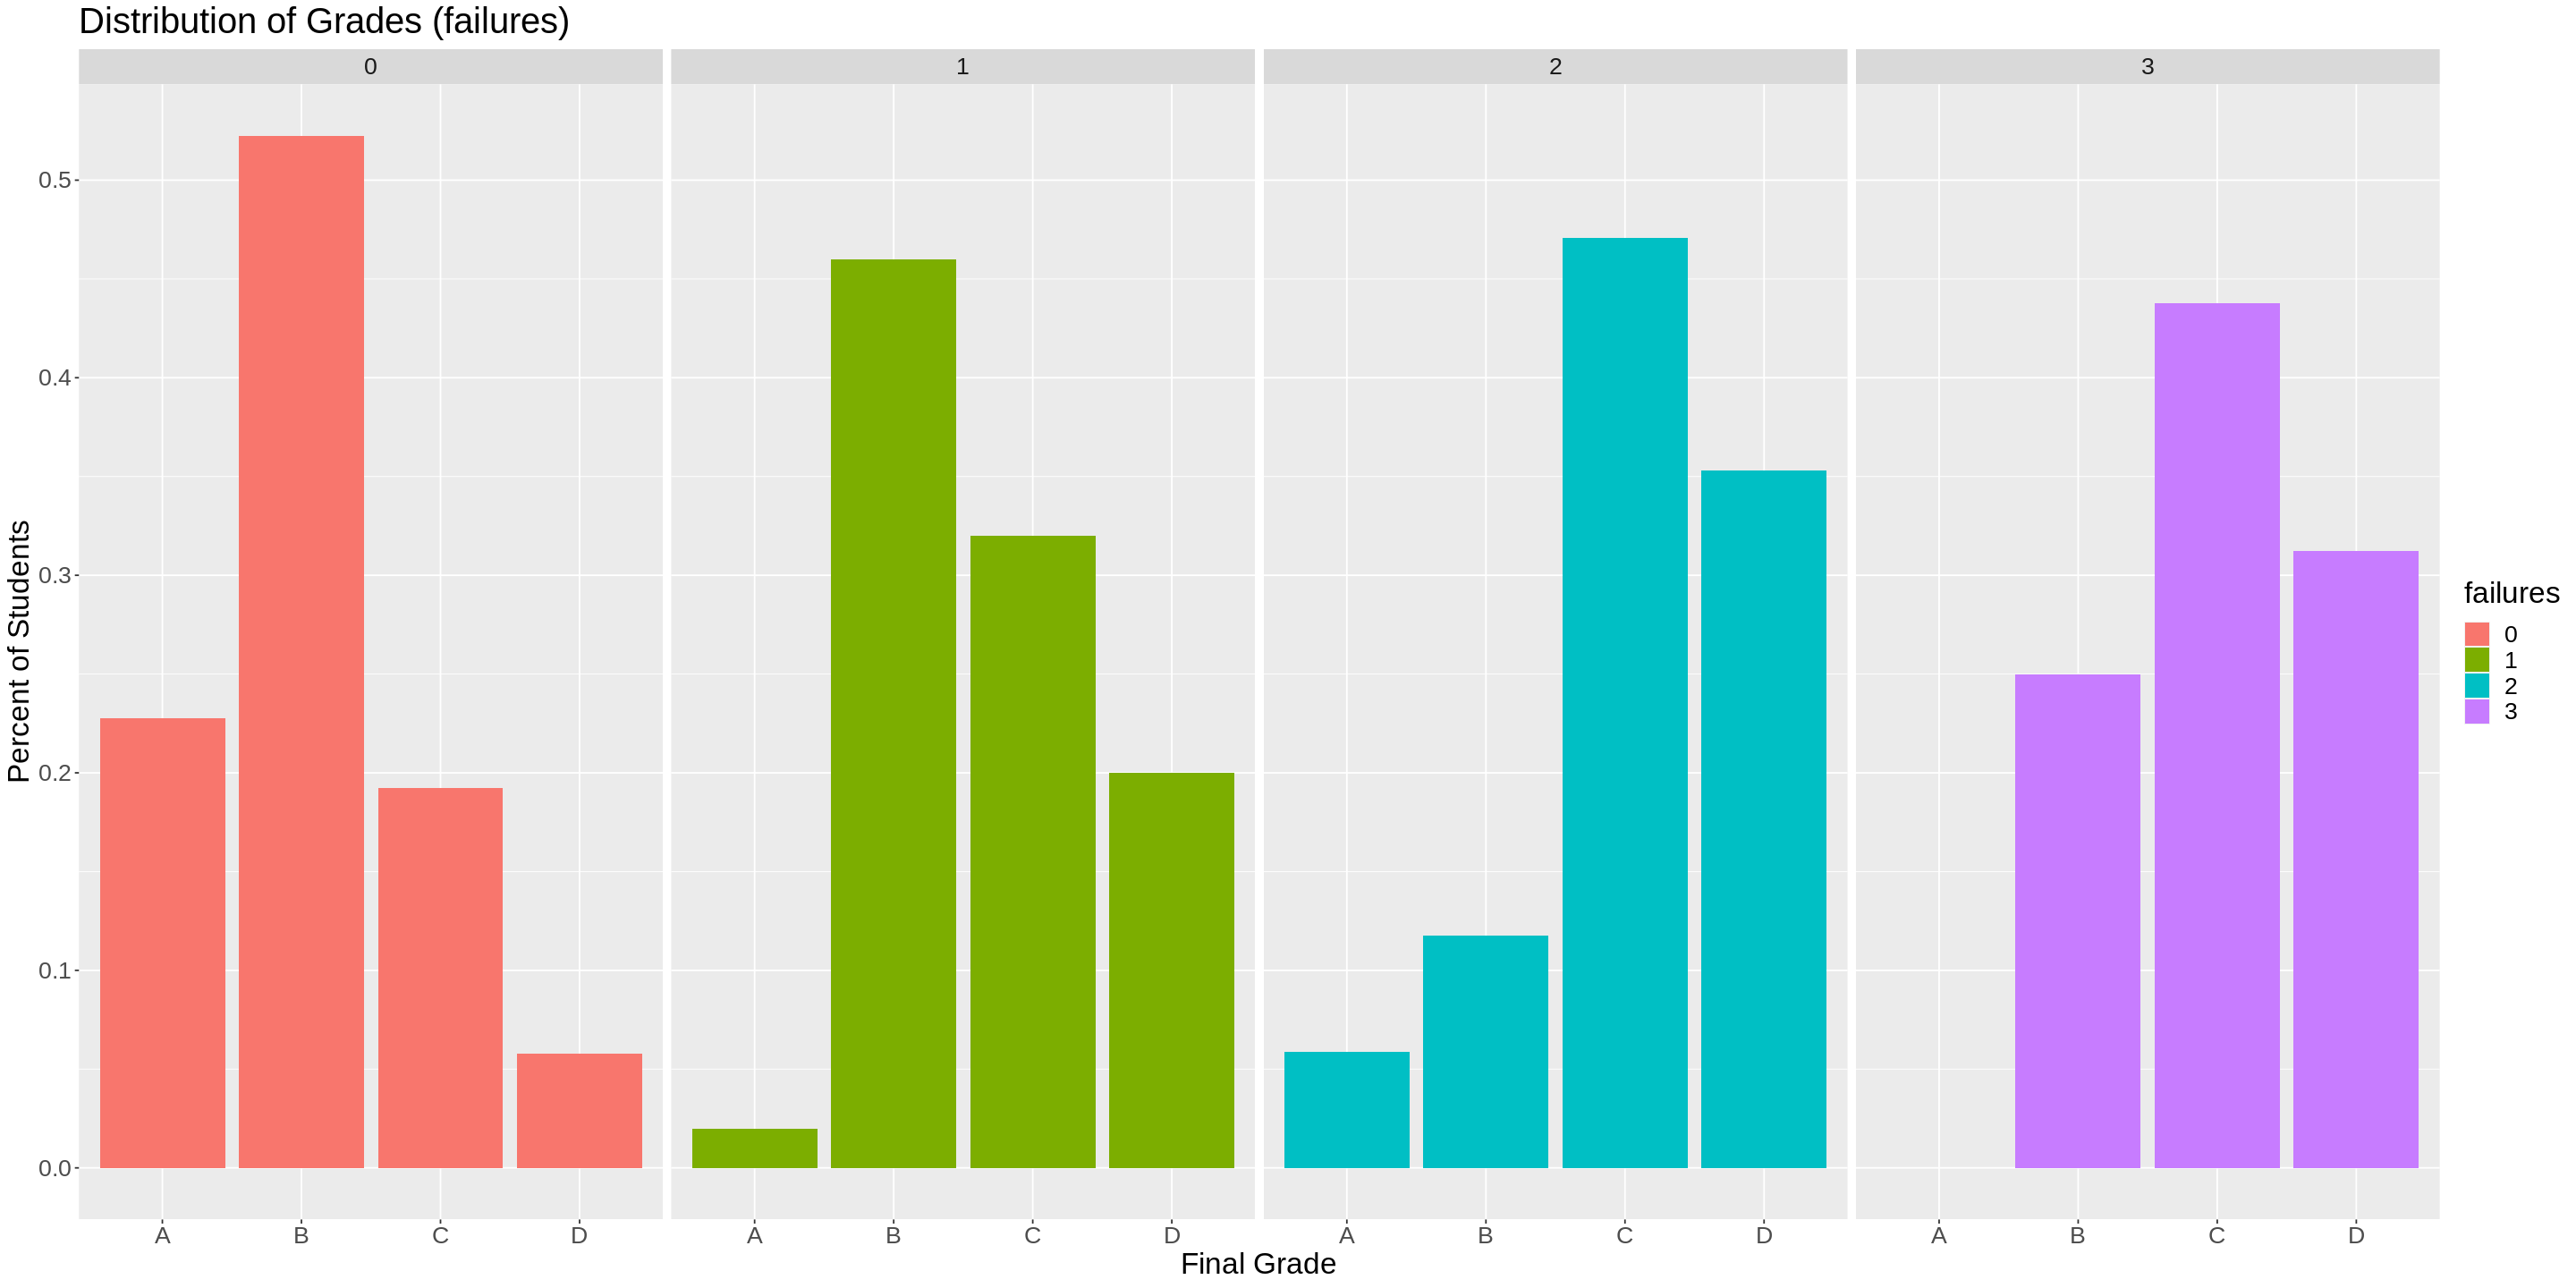

In [34]:
student_data_F

options(repr.plot.width = 24, repr.plot.height = 12) 

studytime_percent <- student_data_F %>%
    group_by(studytime, G3) %>%
    summarise(count = n()) %>%
    mutate(percent = count/sum(count))

# studytime_percent

ggplot(studytime_percent, aes(x = G3, y = percent, fill = factor(studytime))) +
    geom_bar(stat = "identity") +
    xlab("Final Grade") + 
    ylab("Percent of Students") + 
    labs(fill = "study time(hrs)") +
    ggtitle("Distribution of Grades (study time)") +
    theme(text = element_text(size = 20)) +
    facet_grid(.~studytime)



health_percent <- student_data_F %>%
    group_by(health, G3) %>%
    summarise(count = n()) %>%
    mutate(percent = count/sum(count))

# health_percent

ggplot(health_percent, aes(x = G3, y = percent, fill = factor(health))) +
    geom_bar(stat = "identity") +
    xlab("Final Grade") + 
    ylab("Percent of Students") + 
    labs(fill = "health") +
    ggtitle("Distribution of Grades (health)") +
    theme(text = element_text(size = 20)) +
    facet_grid(.~health)



failures_percent <- student_data_F %>%
    group_by(failures, G3) %>%
    summarise(count = n()) %>%
    mutate(percent = count/sum(count))

# failures_percent

ggplot(failures_percent, aes(x = G3, y = percent, fill = factor(failures))) +
    geom_bar(stat = "identity") +
    xlab("Final Grade") + 
    ylab("Percent of Students") + 
    labs(fill = "failures") +
    ggtitle("Distribution of Grades (failures)") +
    theme(text = element_text(size = 20)) +
    facet_grid(.~failures)

`summarise()` regrouping output by 'absences' (override with `.groups` argument)



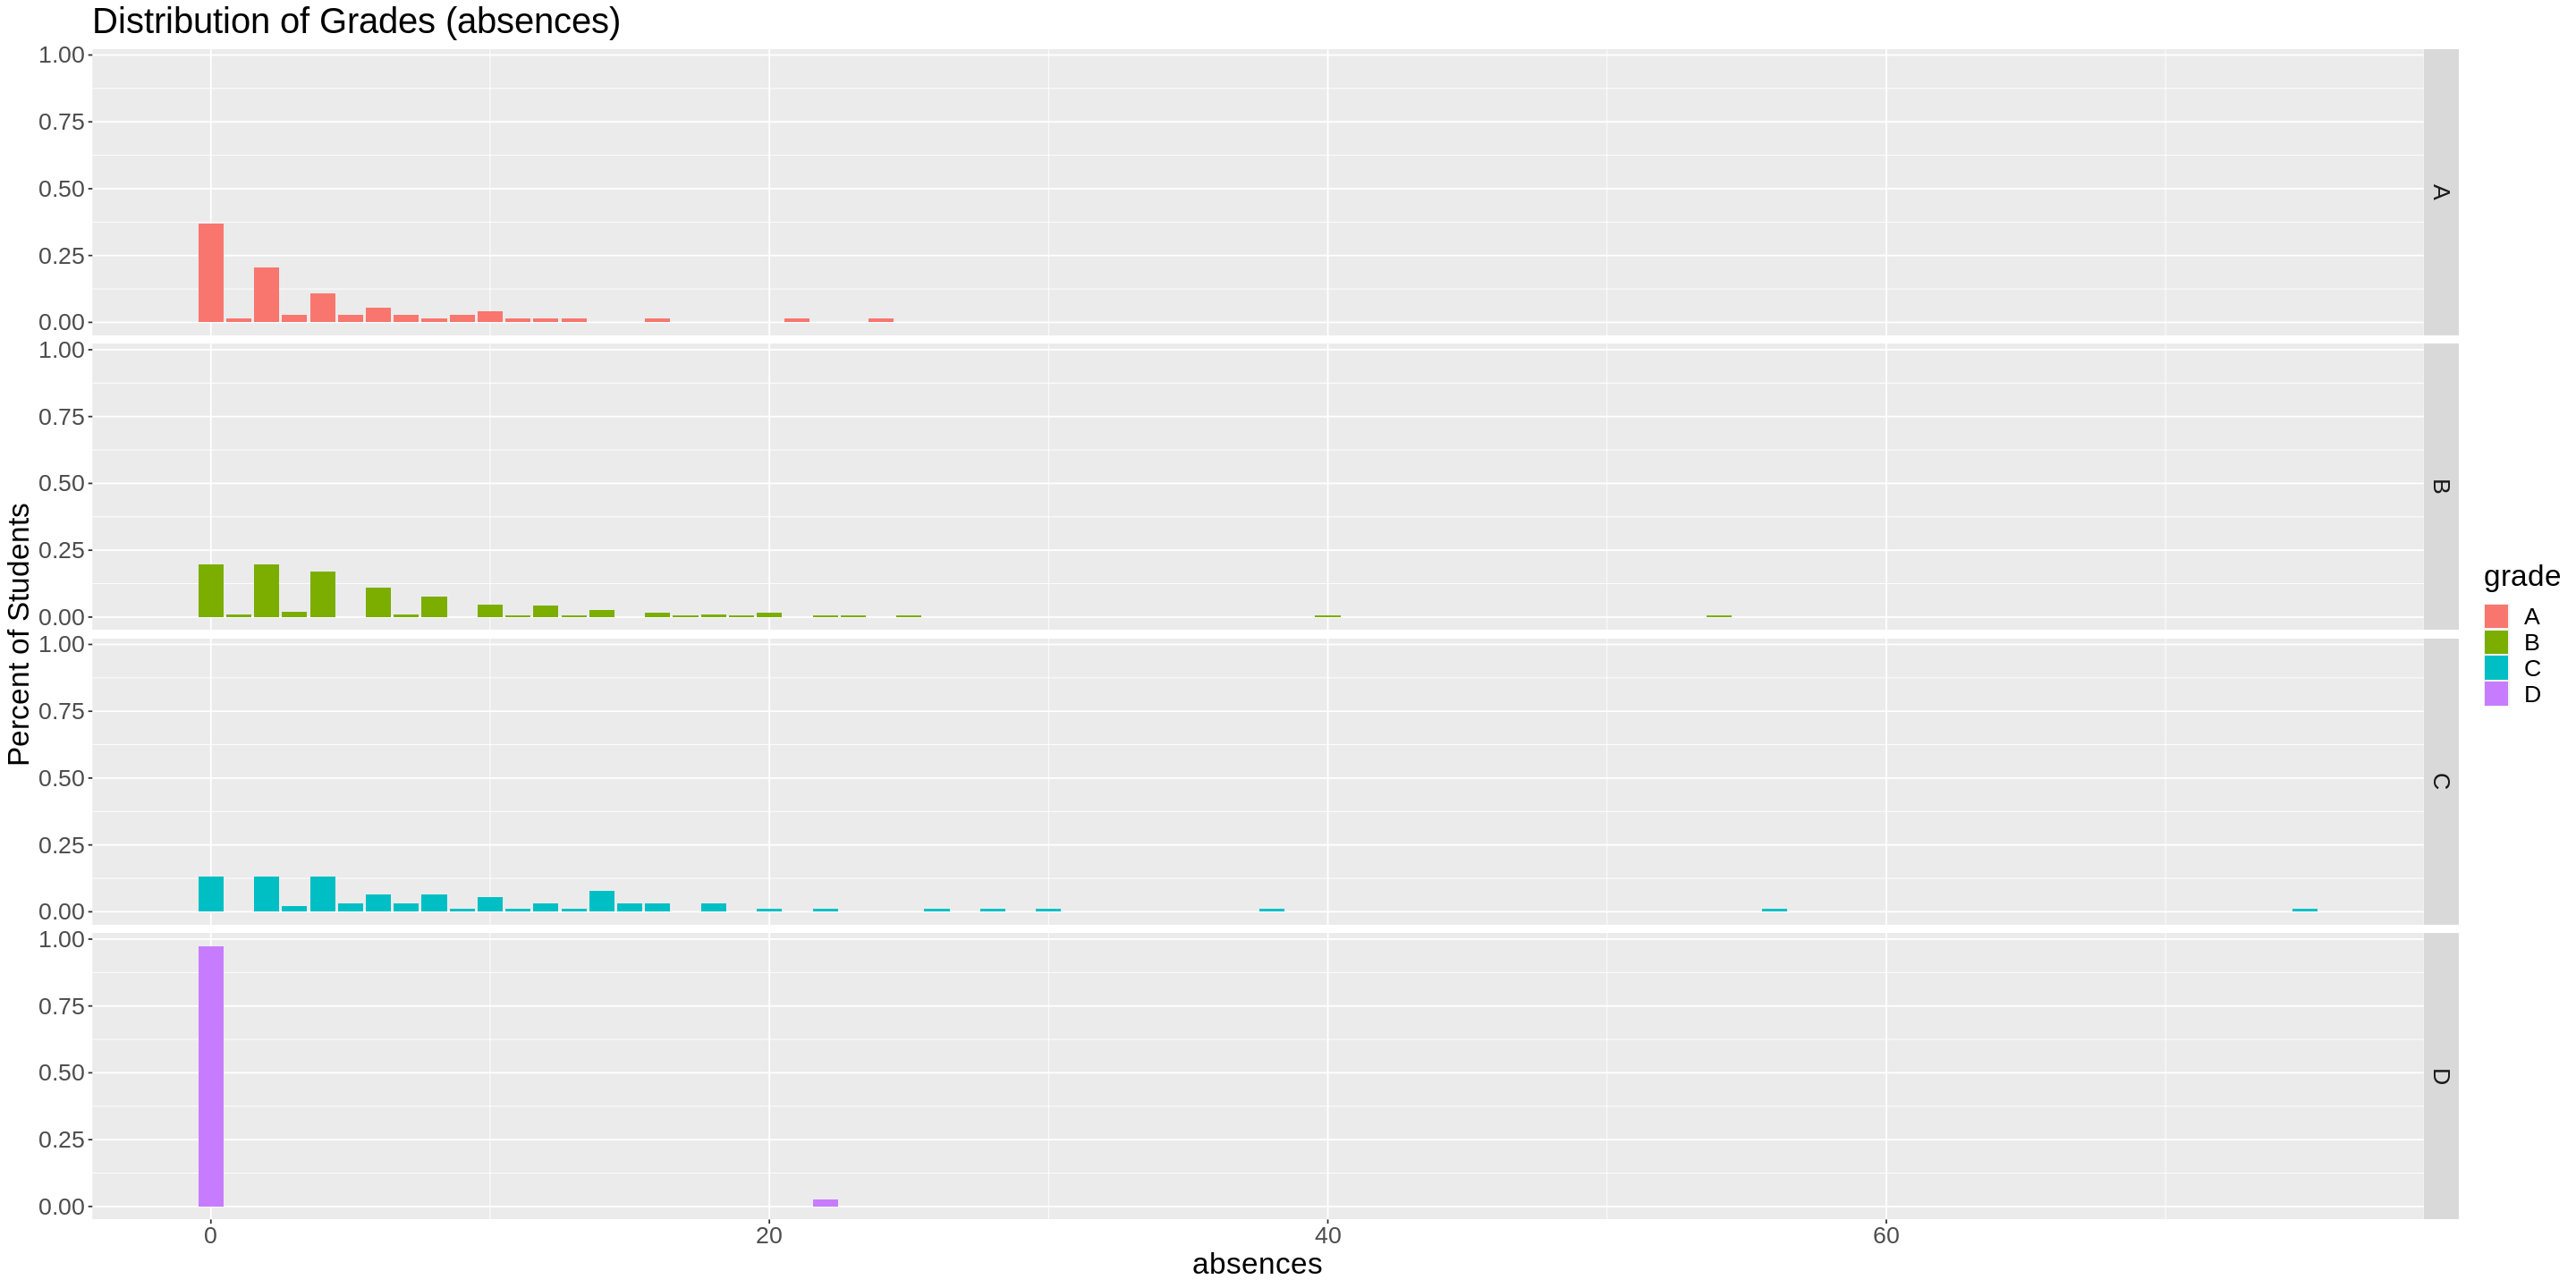

In [35]:
absences_percent <- student_data_F %>% 
    group_by(absences, G3) %>% 
    summarise(count = n()) %>%
    group_by(G3) %>%
    mutate(percent = count/sum(count))

ggplot(absences_percent, aes(x = absences, y = percent, fill = factor(G3))) +
    geom_bar(stat = "identity") +
    xlab("absences") + 
    ylab("Percent of Students") + 
    labs(fill = "grade") +
    ggtitle("Distribution of Grades (absences)") +
    theme(text = element_text(size = 20)) +
    facet_grid(G3~.)


The first 3 graphs are distribution of percentage of students, split up over the different classes the variable we're looking at.

For example, in the topmost graph, it is split between daily hours of study, we see that out of those students with 1 or 2 hours of study, a lower percent got A when compared to the students with 3 or 4 hours.

The graph with absences is done differently, because absences have many different values, using the same strategy I used for the first 3 graphs wouldn't have worked. What I did instead is that I split up the students by grade instead. We see that out of all A students, a high percent of them had zero absences when compared to students with B or C.

studytime,failures,health,absences,G3
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,0,3,6,C
2,0,3,4,C
2,3,3,10,B
3,0,5,2,A
2,0,5,4,B
⋮,⋮,⋮,⋮,⋮
2,2,4,11,C
1,0,2,3,A
1,3,3,3,C


`summarise()` ungrouping output (override with `.groups` argument)



G3,n,percent
<fct>,<int>,<dbl>
A,53,17.78523
B,144,48.32215
C,69,23.15436
D,32,10.73826


K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,multiclass,0.5248844,5,0.03918705,Model03
16,accuracy,multiclass,0.5212645,5,0.03659190,Model04
36,accuracy,multiclass,0.5072956,5,0.02183245,Model08
41,accuracy,multiclass,0.5070655,5,0.01831122,Model09
21,accuracy,multiclass,0.5044849,5,0.03195440,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
31,accuracy,multiclass,0.4972956,5,0.016727235,Model07
51,accuracy,multiclass,0.4933832,5,0.009156129,Model11
46,accuracy,multiclass,0.4933267,5,0.009876025,Model10


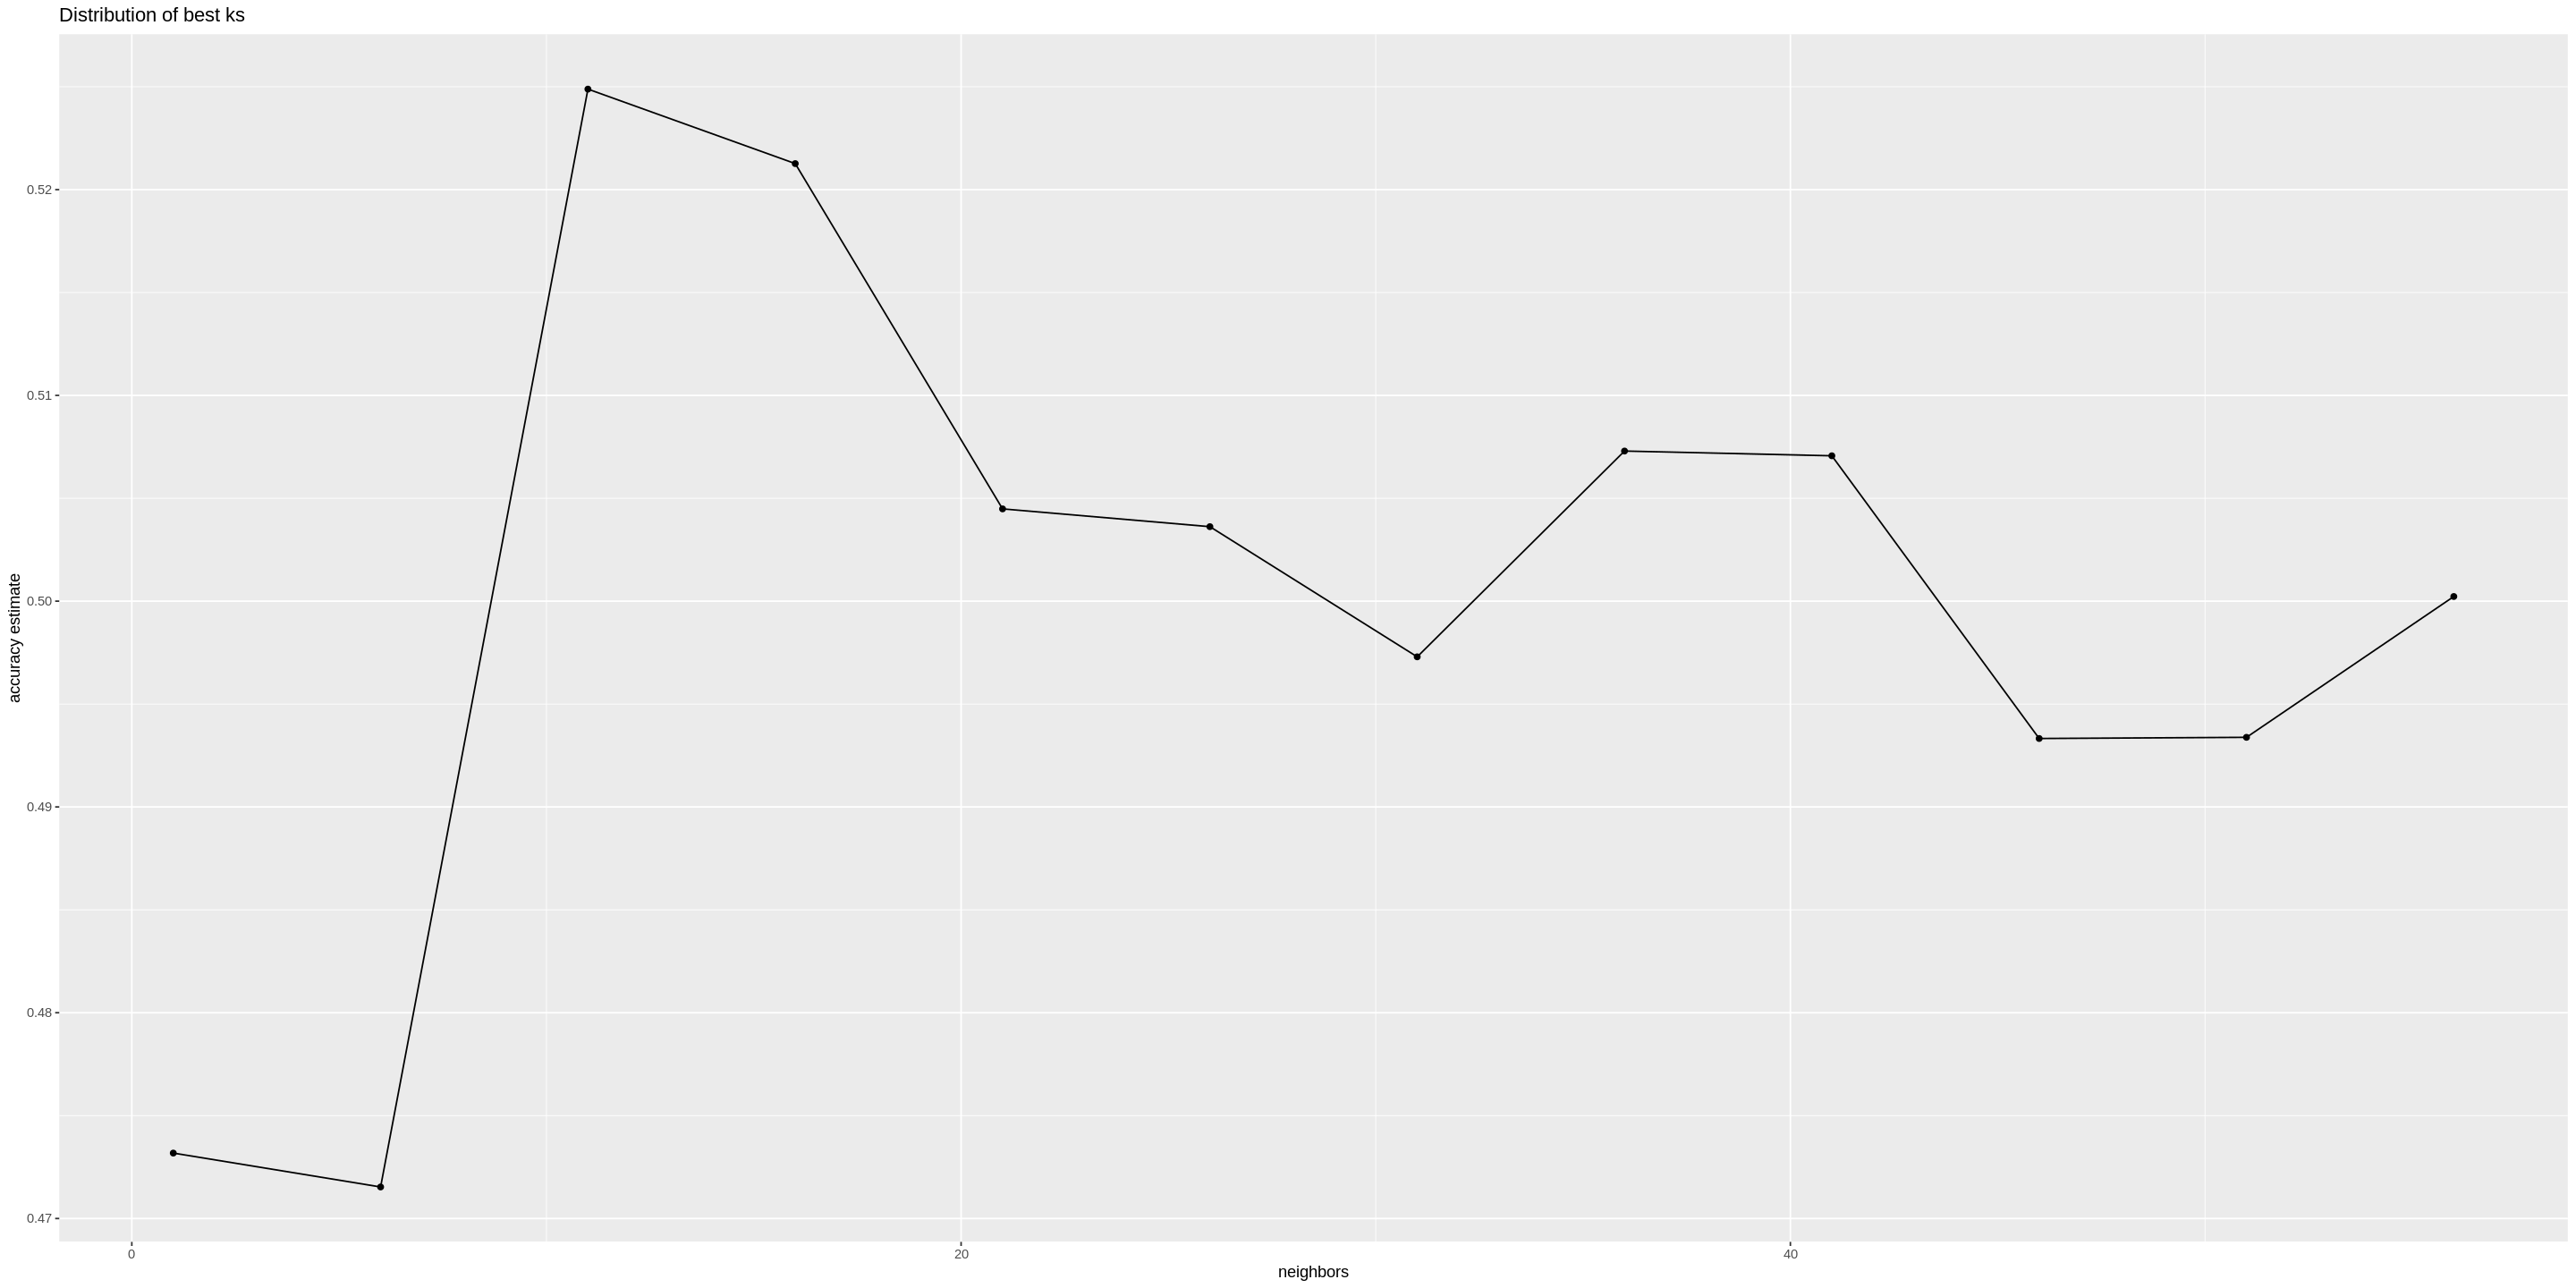

In [37]:
student_data_6 <- student_data %>%
    select(studytime, failures, health,  absences, G3)

student_data_new_6 <- mutate(student_data_6, G3 = case_when(G3 %in% (0:4) ~ "D",
                                                       G3 %in% (5:9) ~ "C",
                                                       G3 %in% (10:14) ~ "B",
                                                       G3 %in% (15:20) ~ "A"),
                        G3 = as.factor(G3))
student_data_new_6

# I will split data 
set.seed(2000)

#split data (choosing )
student_data_split_6<-initial_split(student_data_new_6, prop = 0.75, strata=G3)
#student_data_split_6

student_data_train_6 <- training(student_data_split_6)
#student_data_train_6

student_data_test_6<- testing(student_data_split_6)
#student_data_test_6
# split data into training and testing so we can optimize knn-classfication model

# split into 5 sub section to preform cross validation
student_data_vfold_6<-vfold_cv(student_data_train_6, v = 5, strata = G3)
#student_data_vfold_6

student_grade_distribution_6<- student_data_train_6%>%
    group_by(G3)%>%
    summarize(n=n())%>%
    mutate(percent = 100*n/nrow(student_data_train_6))
student_grade_distribution_6



stand_student_data_6<-recipe(G3 ~ studytime+ failures + health + absences , data = student_data_train_6)%>%
   step_scale(all_predictors())%>%
   step_center(all_predictors())

# stand_student_data_6


#make classifier:

knn_student_data_6<- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
   set_engine("kknn")%>%
   set_mode("classification")
knn_student_data_6
# fitt model

k_vals_6 <- tibble(neighbors = seq(from = 1, to = 40, by = 3))

student_model_fit_6 <- workflow()%>%
   add_recipe(stand_student_data_6)%>%
   add_model(knn_student_data_6)%>%
   tune_grid(resamples = student_data_vfold_6, grid = k_vals)%>%
   collect_metrics()
# student_model_fit_6

accuracy_student_data_6<- student_model_fit_6%>%
    filter(.metric == "accuracy")%>%
    arrange(desc(mean))

accuracy_student_data_6

# best_k_6<- accuracy_student_data_6%>%
#     slice(1:10)
# best_k_6


k_value_dist<- accuracy_student_data_6%>%
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "neighbors", y = "accuracy estimate")+
    ggtitle("Distribution of best ks")

k_value_dist

# shows accuracy vs. k-value: 
#shows optimal range for k that gives highest accuracy 



In [38]:

# so above, we have validated what k gives us the best accuracy, now let us predict it using this: 

student_data_split_2<-initial_split(student_data_new_6, prop = 0.75, strata=G3)
student_data_train_2<- training(student_data_split_2)

student_data_test_2<- testing(student_data_split_2)
                            
recipe_student_data_2<-recipe(G3 ~studytime +failures +health + absences, data = student_data_train_2)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

knn_student_data_2<- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
    set_engine("kknn")%>%
    set_mode("classification")
# knn_student_data_2

student_knn_fit_2 <- workflow()%>%
    add_recipe(recipe_student_data_2)%>%
    add_model(knn_student_data_2)%>%
    fit(data= student_data_train_2)

# student_knn_fit_2

#test predictions: 
student_test_predictions<- predict(student_knn_fit_2, student_data_test_2)%>%
    bind_cols(student_data_test_2)
student_test_predictions

#evaluate accuracy:

accuracy_test_predictions<- student_test_predictions%>%
    metrics(truth = G3, estimate = .pred_class)%>%
    filter(.metric == "accuracy")%>%
    select(.estimate)%>%
    pull()
accuracy_test_predictions


.pred_class,studytime,failures,health,absences,G3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
B,2,0,3,6,C
B,2,0,3,4,C
B,2,0,5,4,B
B,2,0,5,10,A
A,2,0,5,0,A
⋮,⋮,⋮,⋮,⋮,⋮
B,1,1,5,0,D
A,2,0,1,0,C
B,2,1,5,0,D


[1] 0.5204082

In [39]:
# sdf_results <- sdf_predictions %>%
#     bind_cols(sdf_test) %>%
#     conf_mat(truth = G3, estimate = .pred_class)
# sdf_results

print("separate")

confusion_matrix <- student_test_predictions %>%
    conf_mat(truth = G3, estimate = .pred_class)
confusion_matrix
student_test_predictions

[1] "separate"


          Truth
Prediction  A  B  C  D
         A  3  5  2  0
         B 14 42 14  8
         C  0  1  3  1
         D  0  1  1  3

.pred_class,studytime,failures,health,absences,G3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
B,2,0,3,6,C
B,2,0,3,4,C
B,2,0,5,4,B
B,2,0,5,10,A
A,2,0,5,0,A
⋮,⋮,⋮,⋮,⋮,⋮
B,1,1,5,0,D
A,2,0,1,0,C
B,2,1,5,0,D


`summarise()` regrouping output by '.pred_class' (override with `.groups` argument)



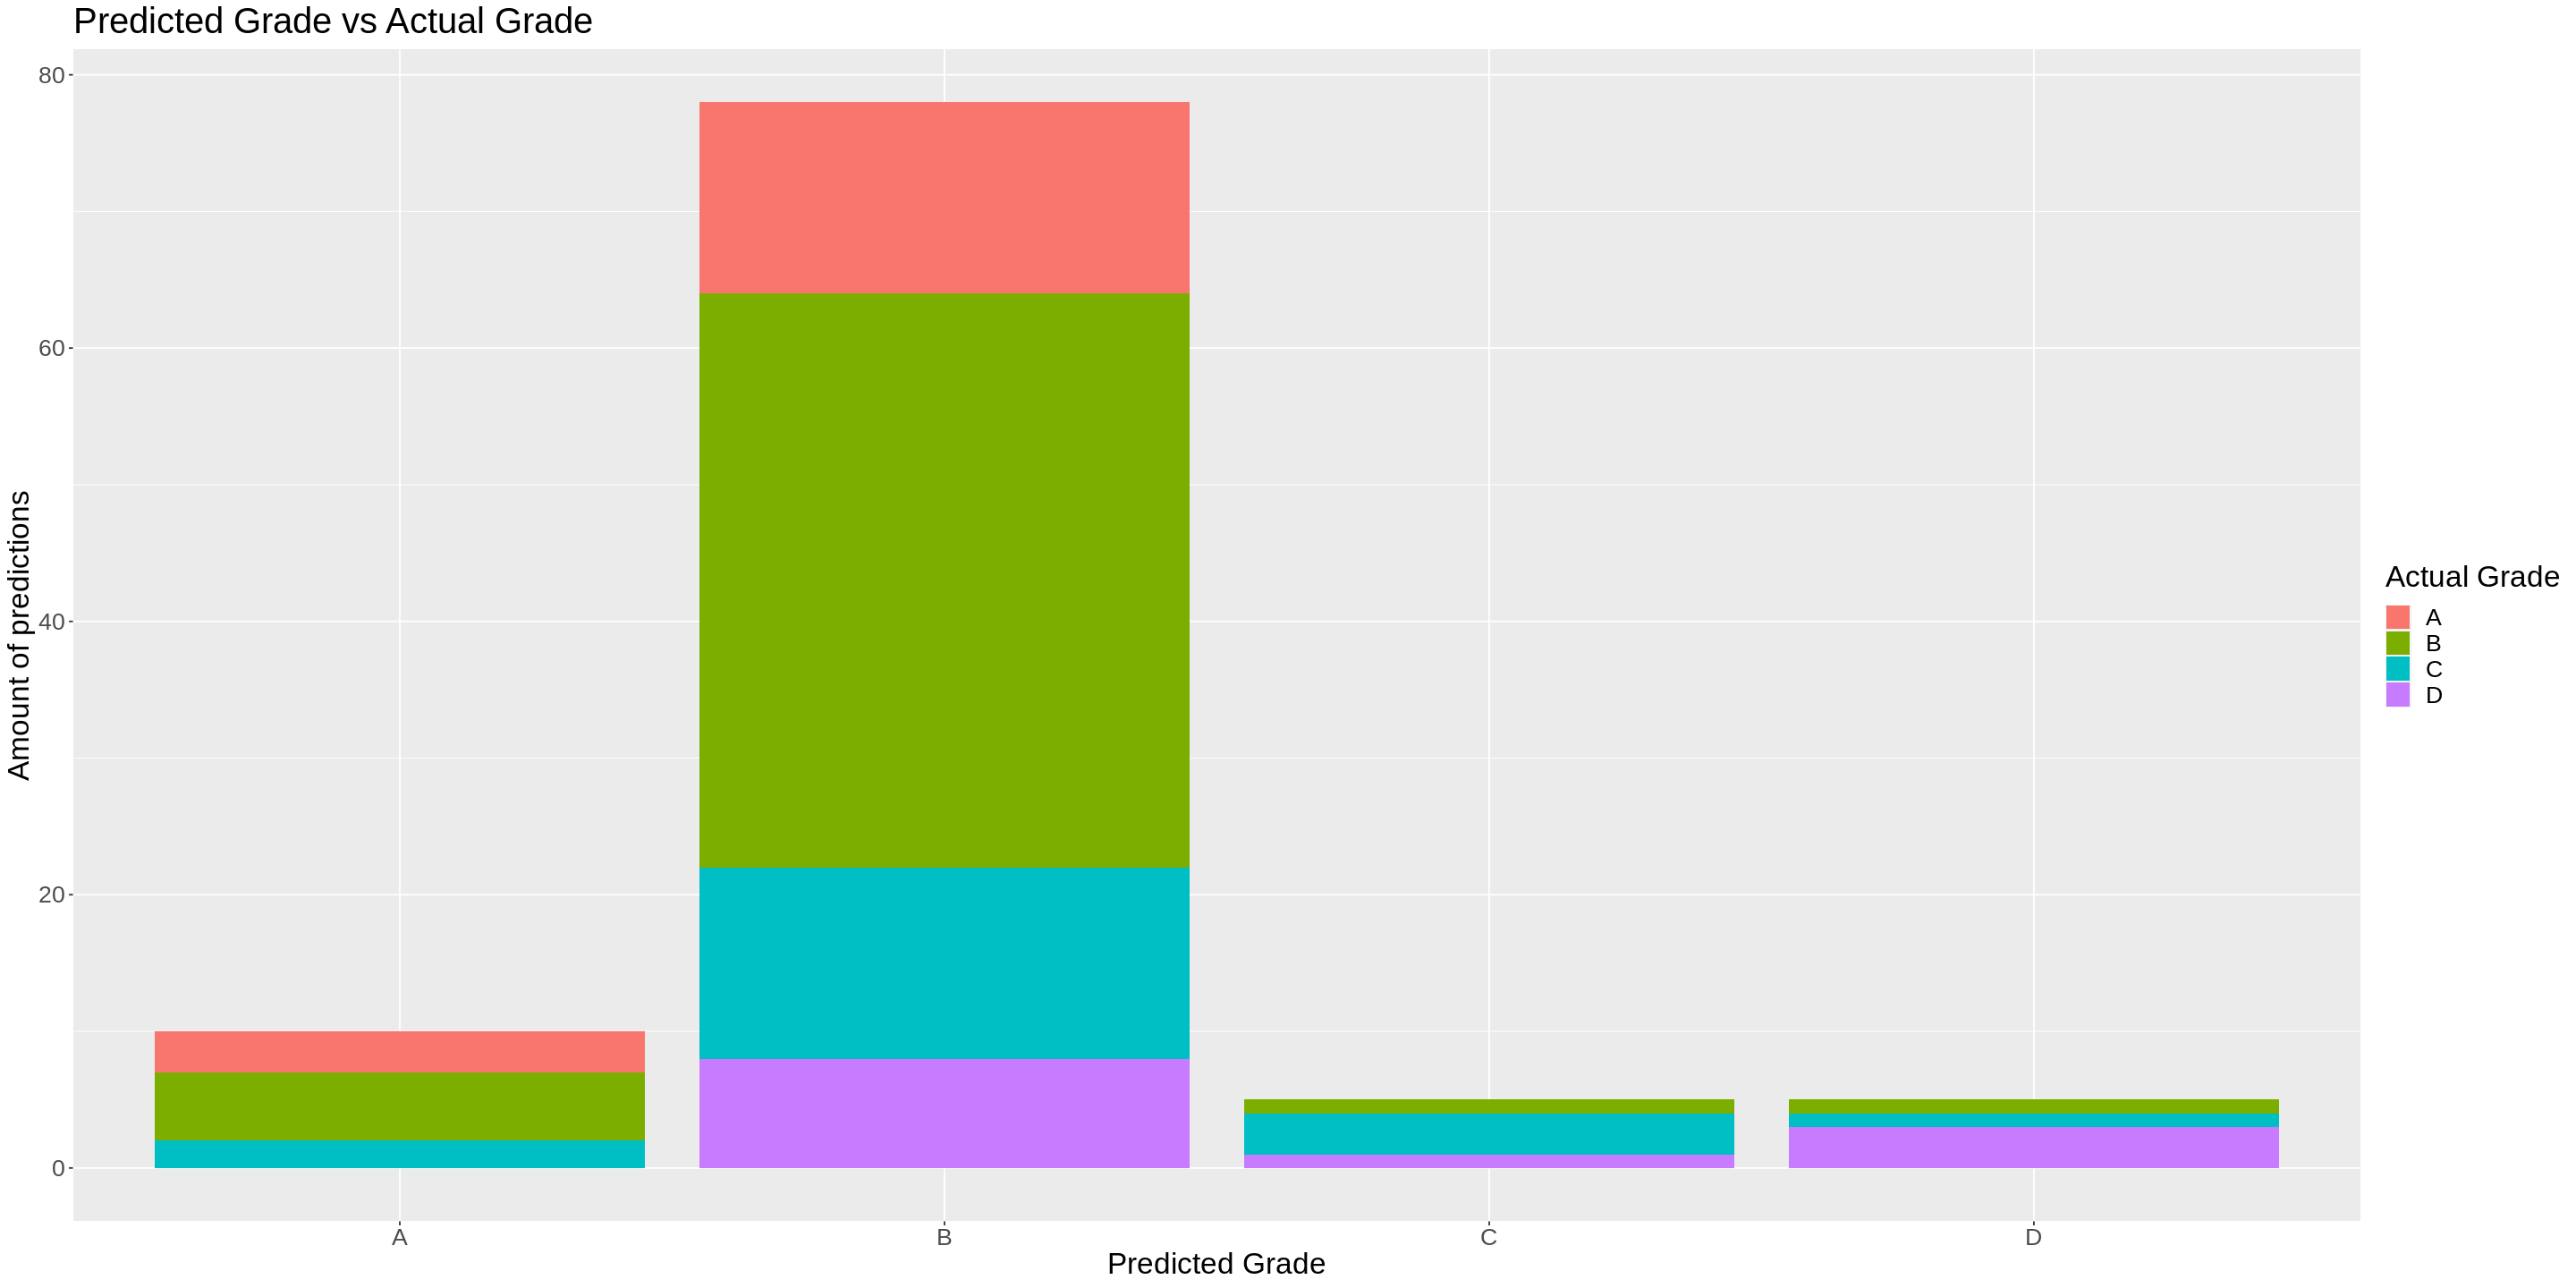

`summarise()` regrouping output by '.pred_class' (override with `.groups` argument)



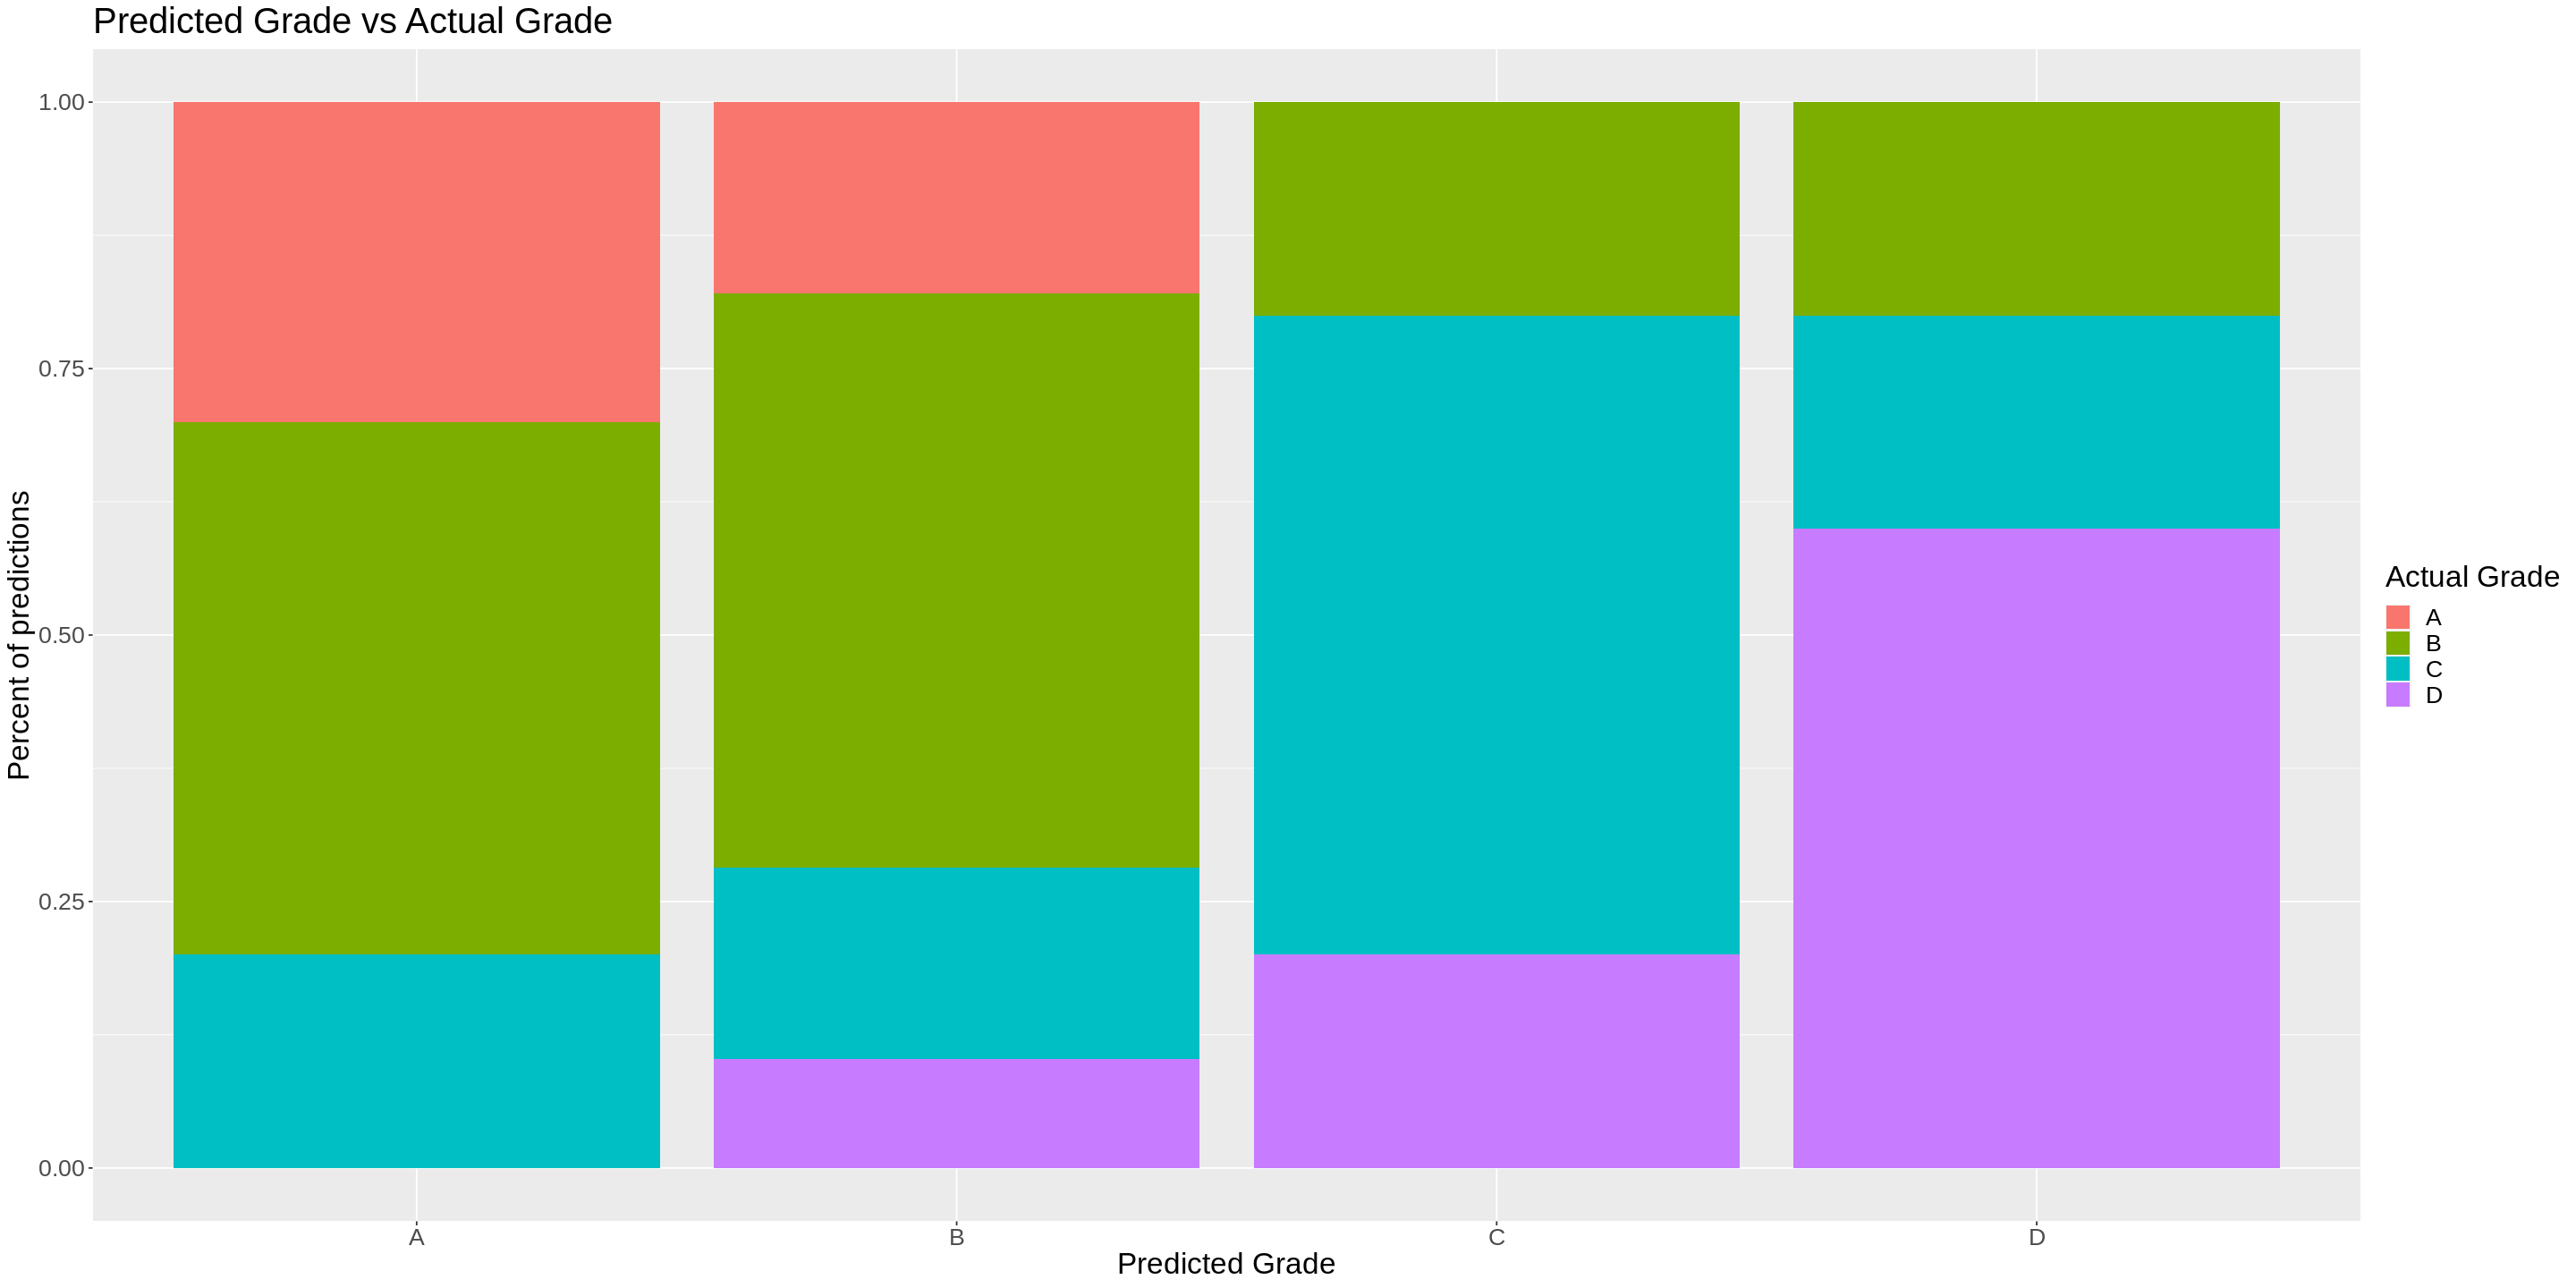

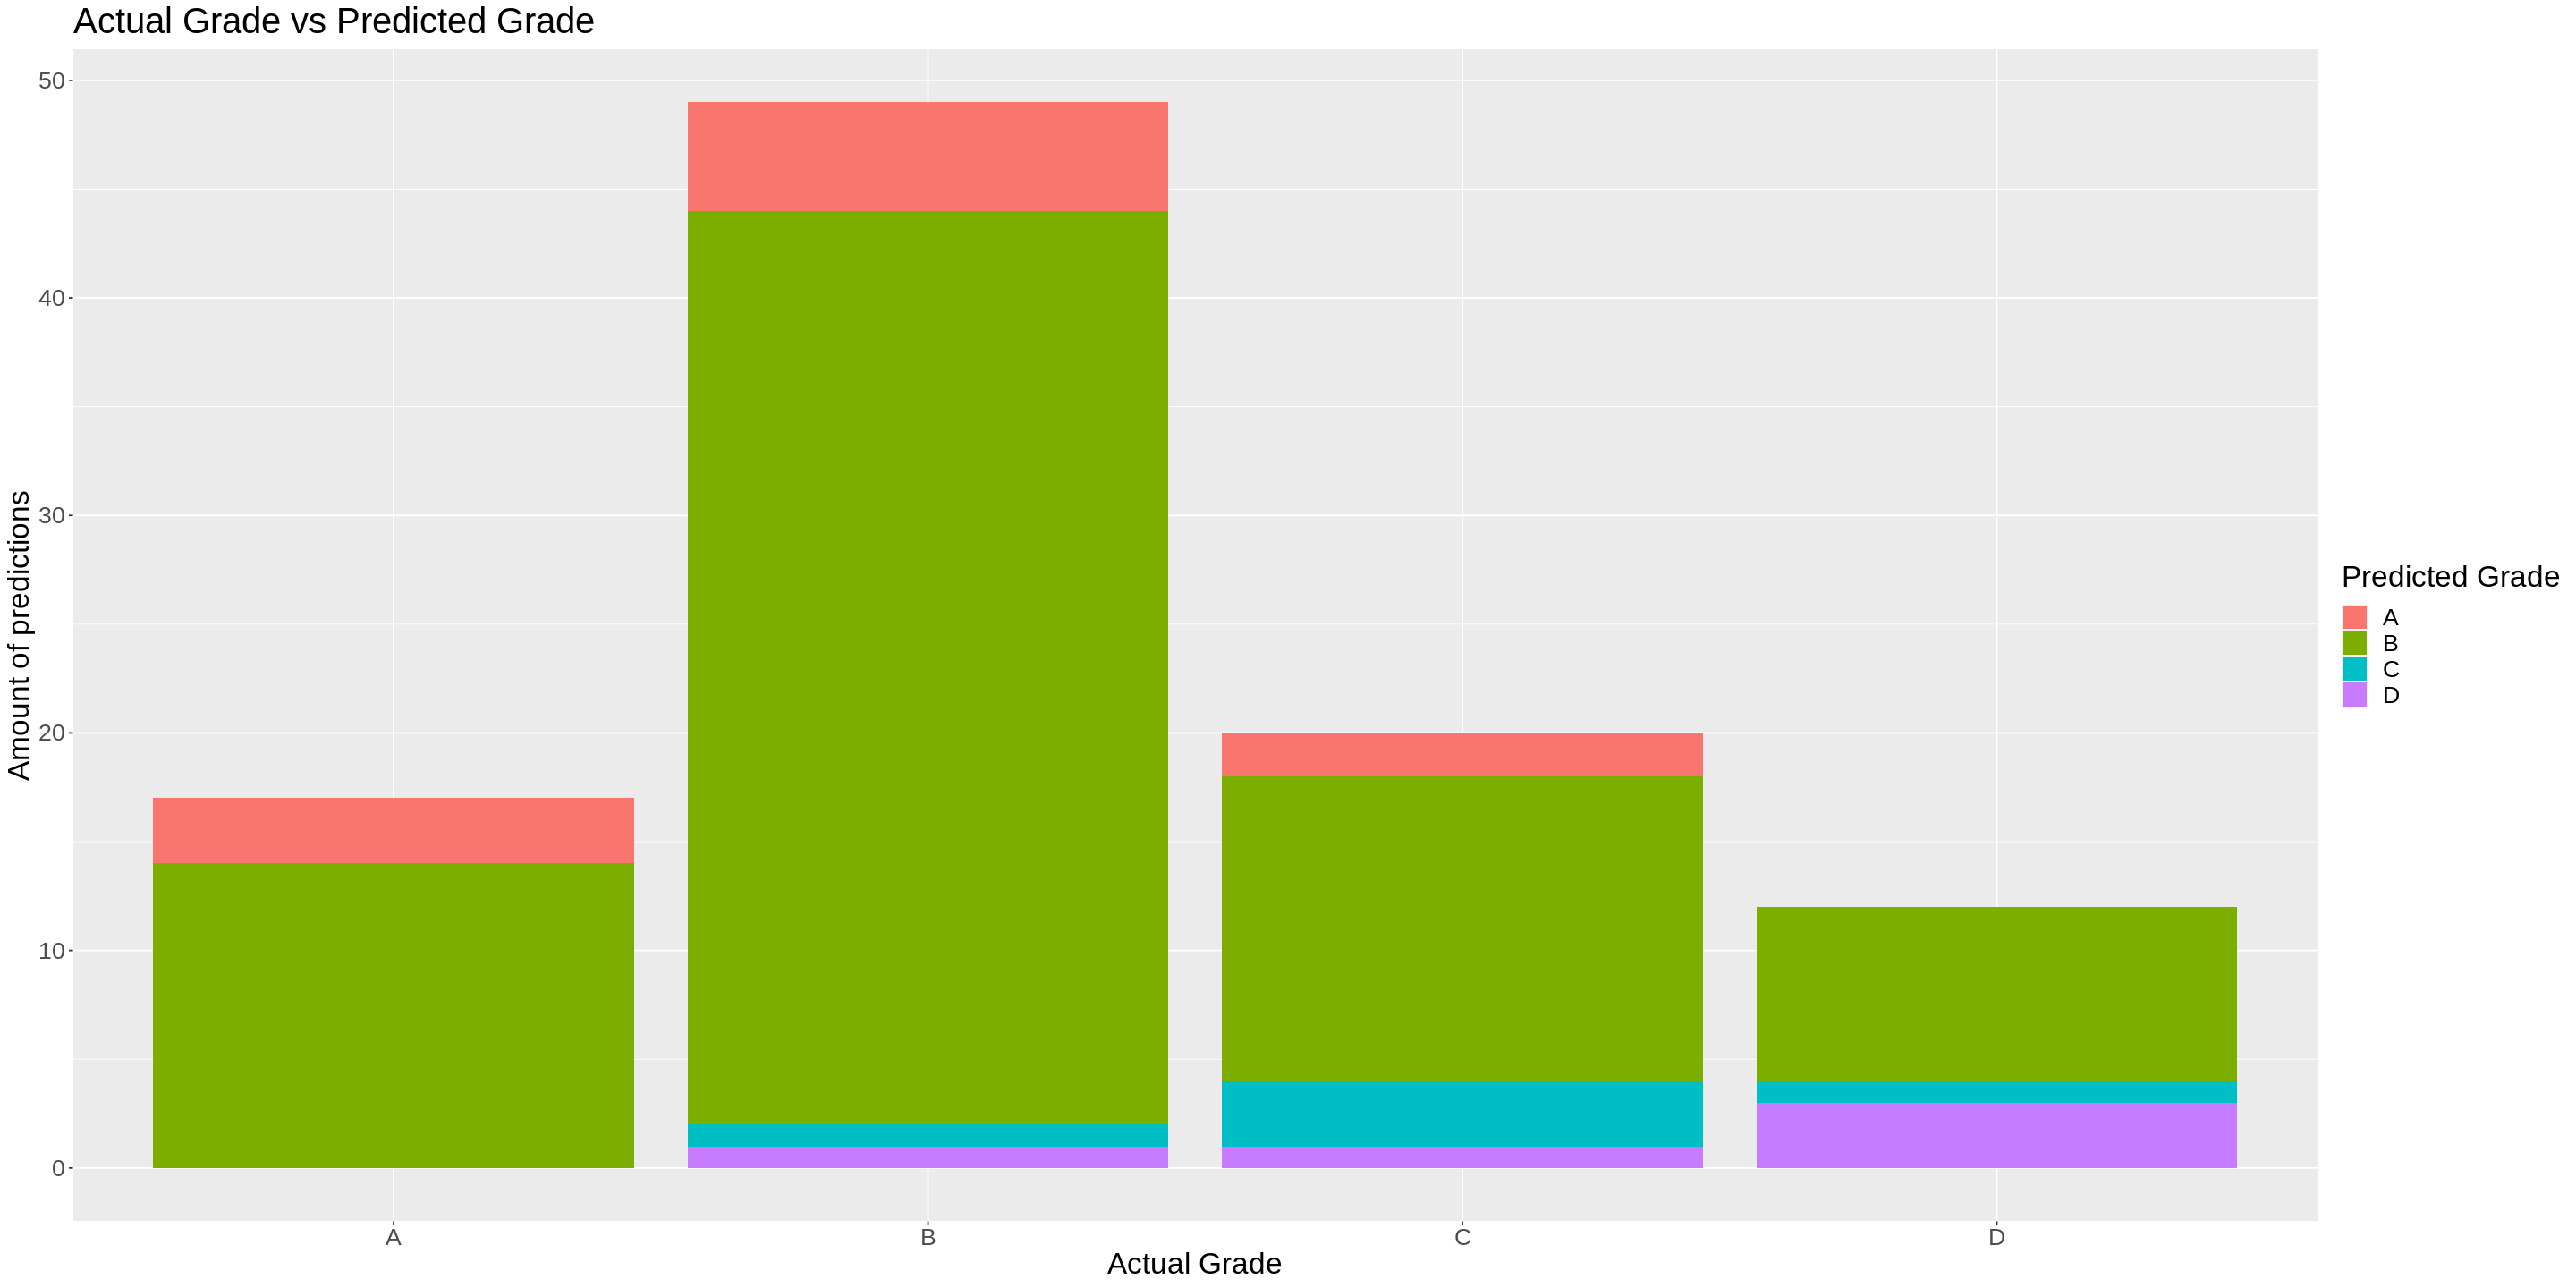

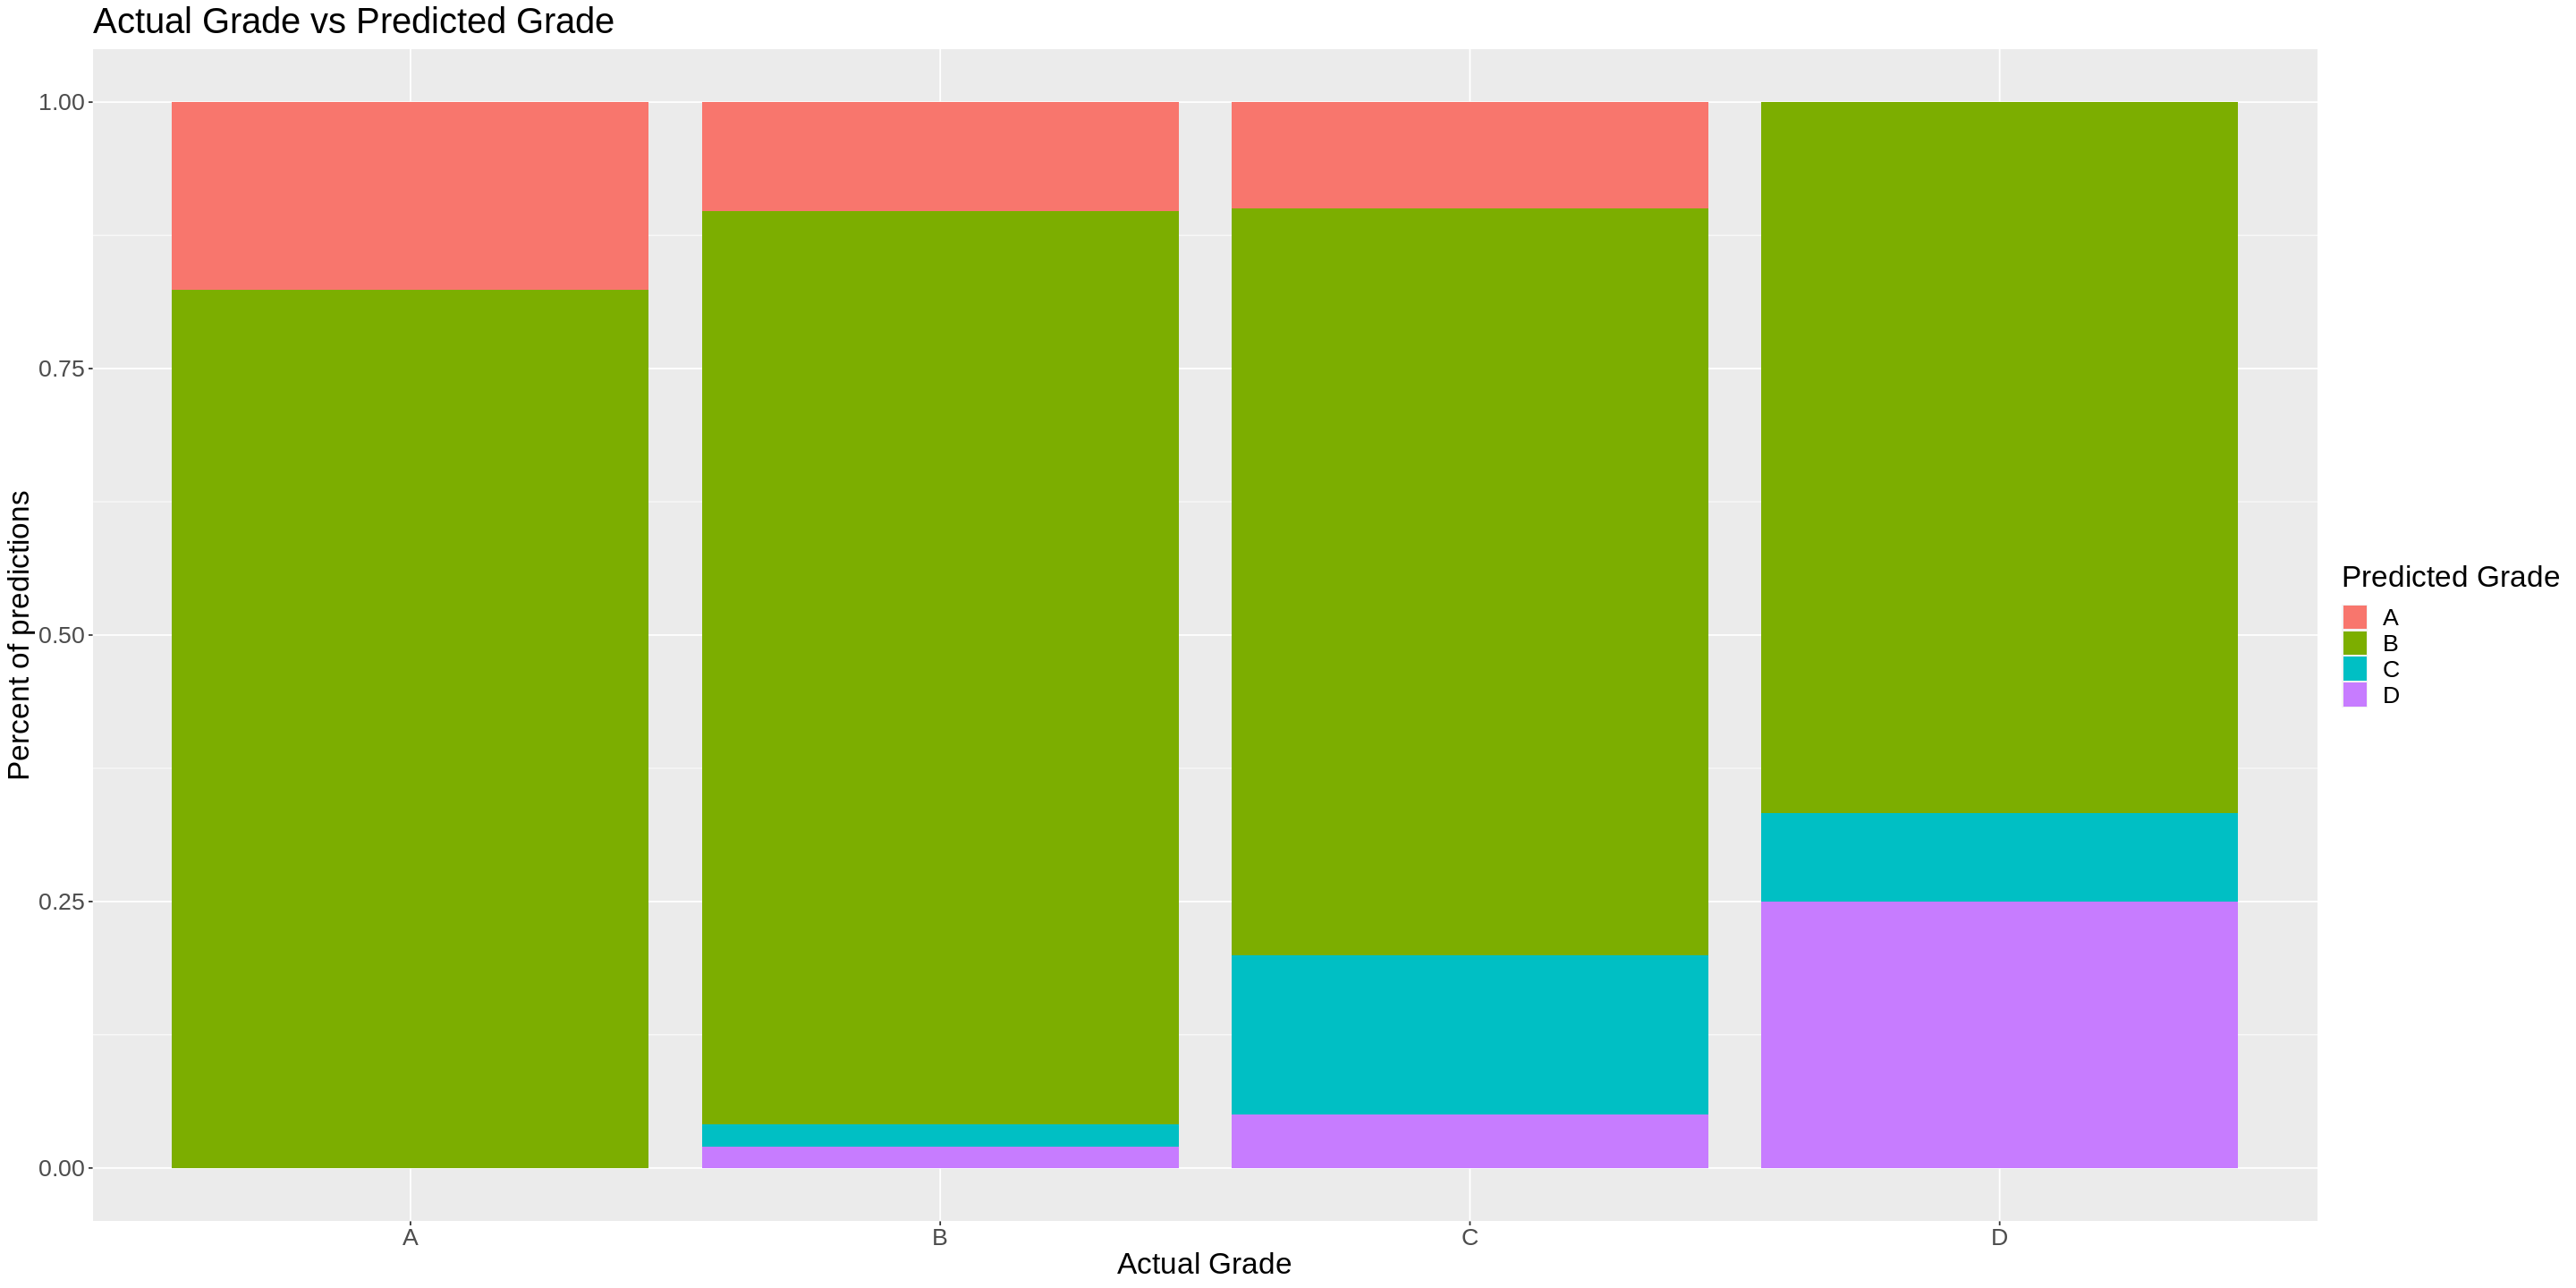

In [40]:
result_percent <- student_test_predictions %>% 
    group_by(.pred_class, G3) %>%
    summarise(count = n()) %>%
    group_by(.pred_class) %>%
    mutate(percent = count/sum(count))
# result_percent

# result_percent %>%
#     group_by(.pred_class) %>%
#     summarise(sum(percent))

ggplot(student_test_predictions, aes(x = .pred_class, fill = G3)) + 
    geom_bar() +
    xlab("Predicted Grade") + 
    ylab("Amount of predictions") + 
    labs(fill = "Actual Grade") +
    ggtitle("Predicted Grade vs Actual Grade") +
    theme(text = element_text(size = 20))

ggplot(result_percent, aes(x = .pred_class, y = percent, fill = G3)) +
    geom_col() +
    xlab("Predicted Grade") + 
    ylab("Percent of predictions") + 
    labs(fill = "Actual Grade") +
    ggtitle("Predicted Grade vs Actual Grade") +
    theme(text = element_text(size = 20))

result_percent_2 <- student_test_predictions %>% 
    group_by(.pred_class, G3) %>%
    summarise(count = n()) %>%
    group_by(G3) %>%
    mutate(percent = count/sum(count))
# result_percent_2

# result_percent_2 %>%
#     group_by(G3) %>%
#     summarise(sum(percent))

ggplot(student_test_predictions, aes(x = G3, fill = .pred_class)) + 
    geom_bar() +
    xlab("Actual Grade") + 
    ylab("Amount of predictions") + 
    labs(fill = "Predicted Grade") +
    ggtitle("Actual Grade vs Predicted Grade") +
    theme(text = element_text(size = 20))

ggplot(result_percent_2, aes(x = G3, y = percent, fill = .pred_class)) +
    geom_col() +
    xlab("Actual Grade") + 
    ylab("Percent of predictions") + 
    labs(fill = "Predicted Grade") +
    ggtitle("Actual Grade vs Predicted Grade") +
    theme(text = element_text(size = 20))